In [1]:
import numpy as np
import pandas as pd

from collections import Counter
import os
import warnings

import random
from pandas.api.types import CategoricalDtype
from plotnine import *
import plotnine as p9

from scipy.stats import chisquare
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import math
import seaborn as sns
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
import requests
import io

%config IPCompleter.greedy = True
%matplotlib inline


In [2]:
#set working dir
os.chdir('C:/Users/Jackson/Documents/Data Science/Sephora Scraper_Attempts')
#read in review data
df = pd.read_csv('sephora_reviews_cleaned.csv')

### Data Summary and Limitations

In [47]:
df.head()

,brand,name,product_id,coverage,finish,formulation,normal_skin,oily_skin,combo_skin,dry_skin,...,first_submission_date,last_submission_date,location,incentivized_review,review_text,brand_image_url,product_image_url,brand_cat,submission_hour,last_mod_hour
0,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,...,2018-01-06 01:04:26,2018-12-08 05:44:51,NaN,NaN,Really good foundation I like it a lot but som...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,FENTY BEAUTY by Rihanna,1,5
1,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,...,2018-10-19 00:29:37,2018-12-07 15:16:13,NaN,NaN,"As someone who is very VERY fair, I have alway...",/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,FENTY BEAUTY by Rihanna,0,15
2,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,...,2018-02-05 21:40:40,2018-12-08 19:07:33,NaN,NaN,First purchase of a foundation of any kind. Wa...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,FENTY BEAUTY by Rihanna,21,19
3,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,...,2018-05-09 00:32:04,2018-12-03 09:54:03,NaN,NaN,I absolutely love this foundation! I get compl...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,FENTY BEAUTY by Rihanna,0,9
4,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,...,2018-12-03 00:40:58,2018-12-06 02:32:21,NaN,NaN,Love this foundation! I was using Too Faced Bo...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,FENTY BEAUTY by Rihanna,0,2


##### Data Limitations

Before we do any analysis, we first check how much information is missing from the collected database. It is unreasonable to think that every row will be information about every column, hence we have to first determine which row/columns should be used with caution when doing the analysis as well as when creating a recommendation system. 

In [4]:
#check number of missing values in each column
df.isnull().sum(axis = 0)

brand                         0
name                          0
product_id                    0
coverage                  87902
finish                    88948
formulation              121729
normal_skin                   0
oily_skin                     0
combo_skin                    0
dry_skin                      0
SPF                           0
user_name                  2943
rating                        0
recommended              194286
skin_type                141615
eye_color                 98481
skin_tone                 93129
skin_concerns            205133
age                      156456
beauty_insider           165018
price                         0
first_submission_date         0
last_submission_date          0
location                 162232
incentivized_review      196561
review_text                   0
brand_image_url               0
product_image_url             0
dtype: int64

In [48]:
df.describe()

,rating,price,submission_hour,last_mod_hour
count,276026.000000,276026.000000,276026.00000,276026.000000
mean,4.123858,39.840765,12.22308,12.134053
std,1.255389,9.481265,7.93037,7.897227
min,1.000000,6.000000,0.00000,0.000000
25%,4.000000,34.000000,4.00000,4.000000
50%,5.000000,39.000000,15.00000,15.000000
75%,5.000000,45.000000,19.00000,19.000000
max,5.000000,120.000000,23.00000,23.000000


The average ratings for products in the foundation category is 4.12 stars (out of 5 Stars). This indicates that the ratings at Sephora are generally very high, with a standard deviation of 1.25 stars. This means that there is some deviation from the generally high ratings.

The average price of foundation is around 40 USD, with a std of 9.5 USD. The cheapest foundatoin you can buy at Sephora is a low 6 USD, while the most expensive foundation is 120 USD. 

In [6]:
df.describe(include = 'all')

,brand,name,product_id,coverage,finish,formulation,normal_skin,oily_skin,combo_skin,dry_skin,...,age,beauty_insider,price,first_submission_date,last_submission_date,location,incentivized_review,review_text,brand_image_url,product_image_url
count,276026,276026,276026,188124,187078,154297,276026,276026,276026,276026,...,119570,111008,276026.000000,276026,276026,113794,79465,276026,276026,276026
unique,63,220,220,3,3,6,2,2,2,2,...,6,4,NaN,263538,145861,20503,2,263481,63,3007
top,bareMinerals,Original Foundation Broad Spectrum SPF 15,P61003,Medium,Matte,Liquid,True,True,True,False,...,25to34,yes,NaN,2011-03-10 02:51:00,2017-12-21 19:16:19,"New York, NY",False,What a wonderful product this powder foundatio...,/contentimages/brands/bareescentuals/082212_ba...,https://www.sephora.com/productimages/sku/s192...
freq,36814,19292,19292,96283,85540,105485,149223,143646,151729,140609,...,42932,80478,NaN,5,434,3065,75361,42,36814,19025
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,39.840765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.481265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,34.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,39.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Overview of Data

##### Foundation Finish Type Analysis

Each product has a described finish which is provided by the brand. Meaning the producers of the product tells Sephora what type of finish their foundation offers. There are 3 Types of Finish: *Matte, Natural, Radiant*.

* Matte finish is a type of foundation which offers the most oil control and is generally known for lasting longer than other types of foundation

* Natural finish offers more shine to skin

* Radiant finish is considered the oilest type of foundation

The plot belows shows that Sephora generally seem to carry more Matte & Natural finish foundations, which could indicate that these are more popular as Sephora would want to carry products which sell more. It seems that *Radiant* finish foundations are generally harder to find, with half the amount of products compared to both *Natural* and *Matte*.

However, it is important to keep in mind more that half of the foundations did not provide this information.


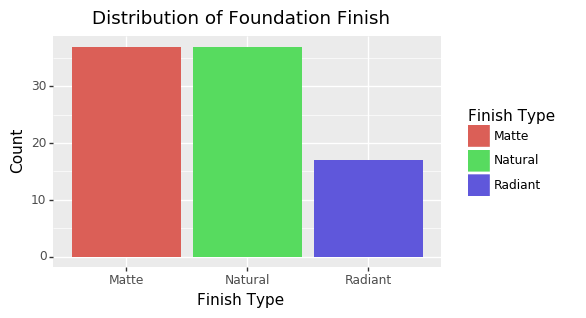

<ggplot: (138082068751)>

In [7]:
finish = [df[df['name'] == i].iloc[0]['finish'] for i in df['name'].unique()] #for every unqiue foundation, find the finish
finish_df = pd.DataFrame({'product': df['name'].unique(), 'finish' : finish}) #create dataframe with two columns: product, finish
finish_df = finish_df[~finish_df['finish'].isna()] #remove rows with missing values

(p9.ggplot(finish_df, aes('finish')) +
geom_bar(aes(fill = 'finish')) +
ggtitle("Distribution of Foundation Finish") +
xlab('Finish Type') +
ylab('Count') +
theme(figure_size = (5,3)) +
labs(fill = "Finish Type "))
#scale_fill_manual(values = [fill with skin tones])    

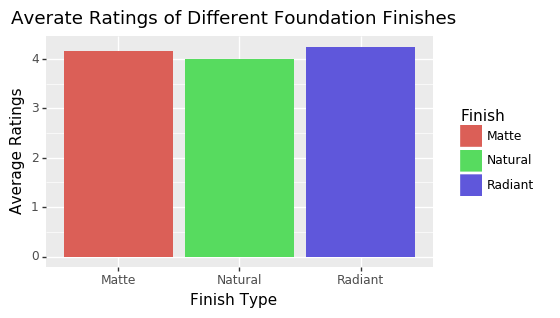

<ggplot: (-9223371898772712132)>

In [8]:
finish_df2 = df.groupby("finish").mean()
finish_df2["Finish"] = finish_df2.index

(p9.ggplot(finish_df2, aes( x = 'Finish', y = 'rating', fill = 'Finish')) +
geom_bar(stat = 'identity') +
ggtitle("Averate Ratings of Different Foundation Finishes") +
xlab("Finish Type") + 
ylab("Average Ratings") + 
theme(figure_size = (5,3)))
#scale_fill_manual(values = [fill with skin tones]) 

Next we can compare the average prices for the different foundation types. From the plot is seems that the foundations are generally prices very similarly with *Nautral* finish having the highest average.

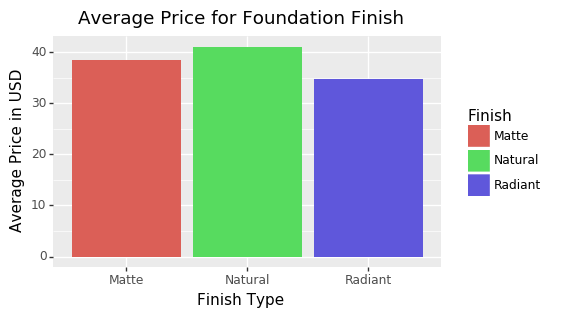

<ggplot: (138079041477)>

In [9]:
(p9.ggplot(finish_df2, aes('Finish', 'price', fill = 'Finish')) +
geom_bar(stat = 'identity') +
ggtitle('Average Price for Foundation Finish') +
xlab('Finish Type') +
ylab('Average Price in USD') +
theme(figure_size = (5,3)))
#scale_fill_manual(values = [fill with skin tones]) 

##### Foundation Coverage Analysis

In addition to finish, many brands provide Sephora with information about the foundation coverage. There are 3 main types of coverage: *Full*, *Light*, *Medium*.

* Full Coverage means the coverage is full
* Light Coverage means the foundation will not cover up major blemish
* Meidum Coverage is somewhere in between

From the plot below is seems the majority of Foundations have medium coverage, with full coverage being the second most popular. It would seem as if *Light* coverage foundation is the least popular.

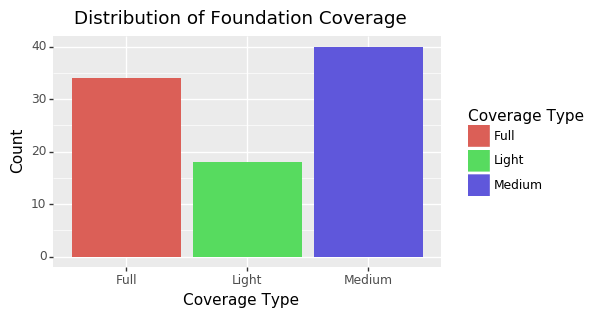

<ggplot: (138082319410)>

In [10]:
coverage = [df[df['name'] == i].iloc[0]['coverage'] for i in df['name'].unique()]
coverage_df = pd.DataFrame({'product': df['name'].unique(), 'coverage' : coverage})
coverage_df = coverage_df[~coverage_df['coverage'].isna()]

(p9.ggplot(coverage_df, aes('coverage')) +
geom_bar(aes(fill = 'coverage')) +
ggtitle('Distribution of Foundation Coverage') +
xlab("Coverage Type") + 
ylab("Count") +
theme(figure_size = (5,3)) +
labs(fill = 'Coverage Type'))
#scale_fill_manual(values = [fill with skin tones]) 

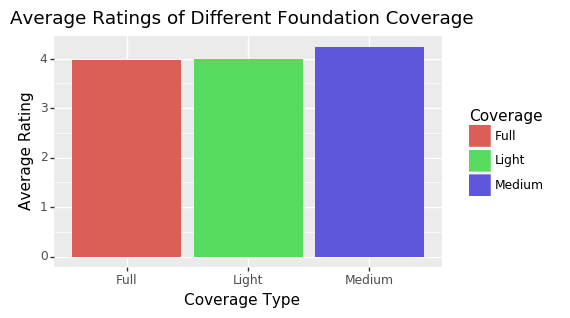

<ggplot: (-9223371898772710326)>

In [11]:
coverage_df2 = df.groupby('coverage').mean()
coverage_df2['Coverage'] = coverage_df2.index

(p9.ggplot(coverage_df2, aes('Coverage', 'rating', fill = 'Coverage')) +
geom_bar(stat = 'identity') +
ggtitle('Average Ratings of Different Foundation Coverage') +
xlab('Coverage Type') + 
ylab('Average Rating') +
theme(figure_size = (5,3)))
#scale_fill_manual(values = [fill with skin tones]) 

It would seem generally all coverage types receieve a similar rating, with medium coverage foundations with the highest average rating by a small amount.

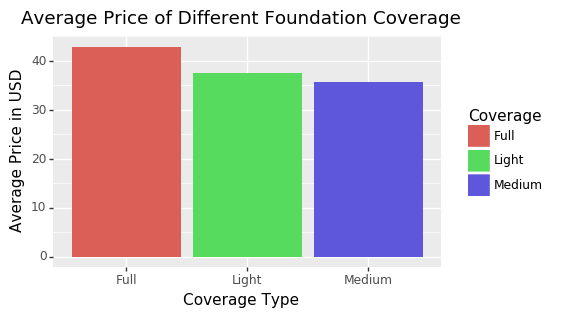

<ggplot: (138082415431)>

In [12]:
(p9.ggplot(coverage_df2, aes('Coverage', 'price', fill = 'Coverage')) +
geom_bar(stat = 'identity') +
ggtitle("Average Price of Different Foundation Coverage") + 
xlab("Coverage Type") +
ylab("Average Price in USD") +
theme(figure_size = (5,3)))
#scale_fill_manual(values = [fill with skin tones]) 

From the plot it seems that generally, Full type coverage foundation is more pricey than the other two types. And Medium type coverage foundations to be the cheapest of the 3 options.

### Distribution of Formluation Types

Lastly, we have can do a similar analysis on the foundation formluation types. There are 5 main formulations:

* Cream
* Liquid
* Loose
* Pressed
* Stick

From the plot it is clear that Liquid formulation Foundations are by far the most popular. However, keep in mind that the vast majority of foundations did not include formulation type in their description. Out of 217, only 48 products had information about formulation type. Furthermore, in most skincare/make-up routines women generally have more than one type of foundation, and it is very common that the base layer is a liquid foundation topped off with a pressed or loose foudation. This could explain why these two types of foundations are generally more popular.

C:\Users\Jackson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\Jackson\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


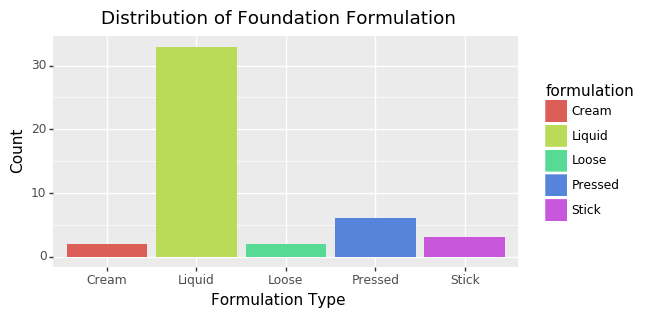

<ggplot: (138082352178)>

In [13]:
#change values from liquid stick to liquid foundation
df = df.set_value(201967, 'formulation', 'Liquid')
df = df.set_value(202207, 'formulation', 'Liquid')

formulation = [df[df['name']==i].iloc[0]['formulation'] for i in df['name'].unique()]
formulation_df = pd.DataFrame({'product': df['name'].unique(), 'formulation': formulation})
formulation_df = formulation_df[~formulation_df['formulation'].isna()]

(p9.ggplot(formulation_df, aes('formulation')) +
geom_bar(aes(fill = 'formulation')) +
ggtitle('Distribution of Foundation Formulation') +
xlab("Formulation Type") + 
ylab("Count") +
theme(figure_size = (6,3)))

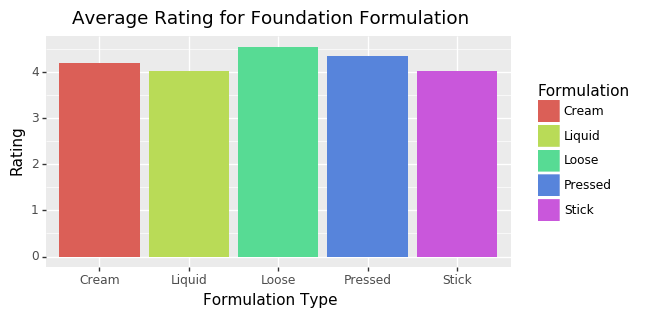

<ggplot: (138082415403)>

In [14]:
formulation_df2 = df.groupby('formulation').mean()
formulation_df2["Formulation"] = formulation_df2.index
formulation_df2 = formulation_df2[formulation_df2["Formulation"] != "LiquidStick"]

(p9.ggplot(formulation_df2, aes('Formulation','rating', fill = 'Formulation')) +
geom_bar(stat = 'identity') +
ggtitle('Average Rating for Foundation Formulation') +
xlab("Formulation Type") + 
ylab("Rating") +
theme(figure_size = (6,3)))

Once again, it seems as the different types of formulation does not affect the ratings given to a foundation

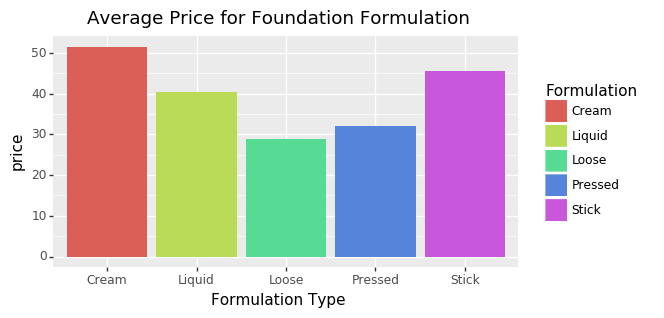

<ggplot: (-9223371898772326726)>

In [15]:
(p9.ggplot(formulation_df2, aes('Formulation','price', fill = 'Formulation')) +
geom_bar(stat = 'identity') +
ggtitle('Average Price for Foundation Formulation') +
xlab("Formulation Type") + 
ylab("price") +
theme(figure_size = (6,3)))

From the plot it it clear that Cream foundations are generally more expensive than the rest of the formulations, with Sticks closely following. Loose type foundations are generally the cheapest. 

It's worth noting that there were very few Cream foundations, so it may be artifically inflated by a lack of products. This also applies to Loose foundations.

### Overview of Brands

That that we've done some overall product distributions, we can be begin to explore the brands in our data. I decided to use *brands* instead of *products* becuase we have 217 products, which is simply too many to analyze individually. Thus *brands* would be a good way to group the products, as each brand has their own standard for products and customers generally stick to a brand.

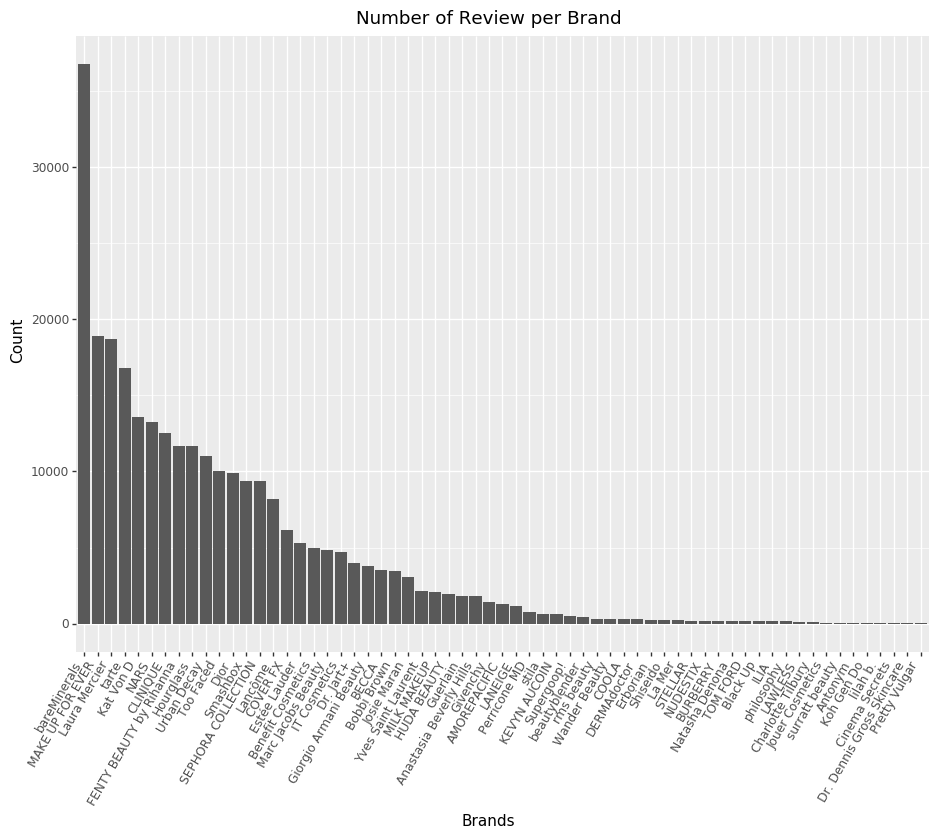

<ggplot: (138082314111)>

In [49]:
#reorder data frame by value counts of brand
brand_list = df['brand'].value_counts().index.tolist()
brand_cat = CategoricalDtype(categories = brand_list, ordered = True)
df['brand_cat'] = df['brand'].astype(str).astype(brand_cat)

(p9.ggplot(df, aes('brand_cat')) + 
geom_bar() +
theme(figure_size = (11,8), axis_text_x = element_text(rotation = 60, hjust = 1)) +
ggtitle("Number of Review per Brand") +
xlab("Brands") +
ylab("Count"))

The most popular brand by far is Bare Minerals. Bare Minerals's products pulled in over 35,000 reviews, which the MAKE UP FOR EVER and Laura Mercier pulled in around 18,000 reviews.

A quick google search explains why Bare Minerals is so popular. Bare Minerals mainly focus on foundations which would explain why they are so popular as this is only from the foundation section of Sephora. Furthermore, it seems Bare Minerals helped popularize loose mineral powders for foundations as opposed to compact powder ones.

In [17]:
#crate new brand_df data frame with aggregated info about brands
brands = list(df['brand'].unique())
avg_reviews = [round(df[df['brand'] == i]['rating'].mean(),2) for i in brands]
count = df['brand'].value_counts()
brand_df = pd.DataFrame({'brand': brands, 'averageReview': avg_reviews, 'Count': count}).reset_index(drop = True)
brand_df.head()

,brand,averageReview,Count
0,FENTY BEAUTY by Rihanna,4.10,36814
1,MAKE UP FOR EVER,4.07,18902
2,Giorgio Armani Beauty,4.25,18737
3,Estée Lauder,4.39,16834
4,IT Cosmetics,4.01,13552


In [18]:
#function for finding 95% CI for ratings
def nfci(brand):
    #input : brand
    #output : lower and upper confidence limits for brand in dataframe
    dat = df[df['brand'] == brand]
    sdv = np.std(dat['rating'])
    lower = np.mean(dat['rating'] - (1.96*(sdv/math.sqrt(len(dat)))))
    upper = np.mean(dat['rating'] + (1.96*(sdv/math.sqrt(len(dat)))))
    return lower, upper

#add lower and upper of rating CI to brand_df
brand_df['lower_rating_lim'] = [nfci(i)[0] for i in brand_df['brand']]
brand_df['upper_rating_lim'] = [nfci(i)[1] for i in brand_df['brand']]

#reorder brand_df in descending order based on averageReview
brand_order1 = brand_df.sort_values("averageReview").reset_index(drop = True)['brand']
brand_df['brand'] = pd.Categorical(brand_df['brand'], categories=brand_order1, ordered = True)

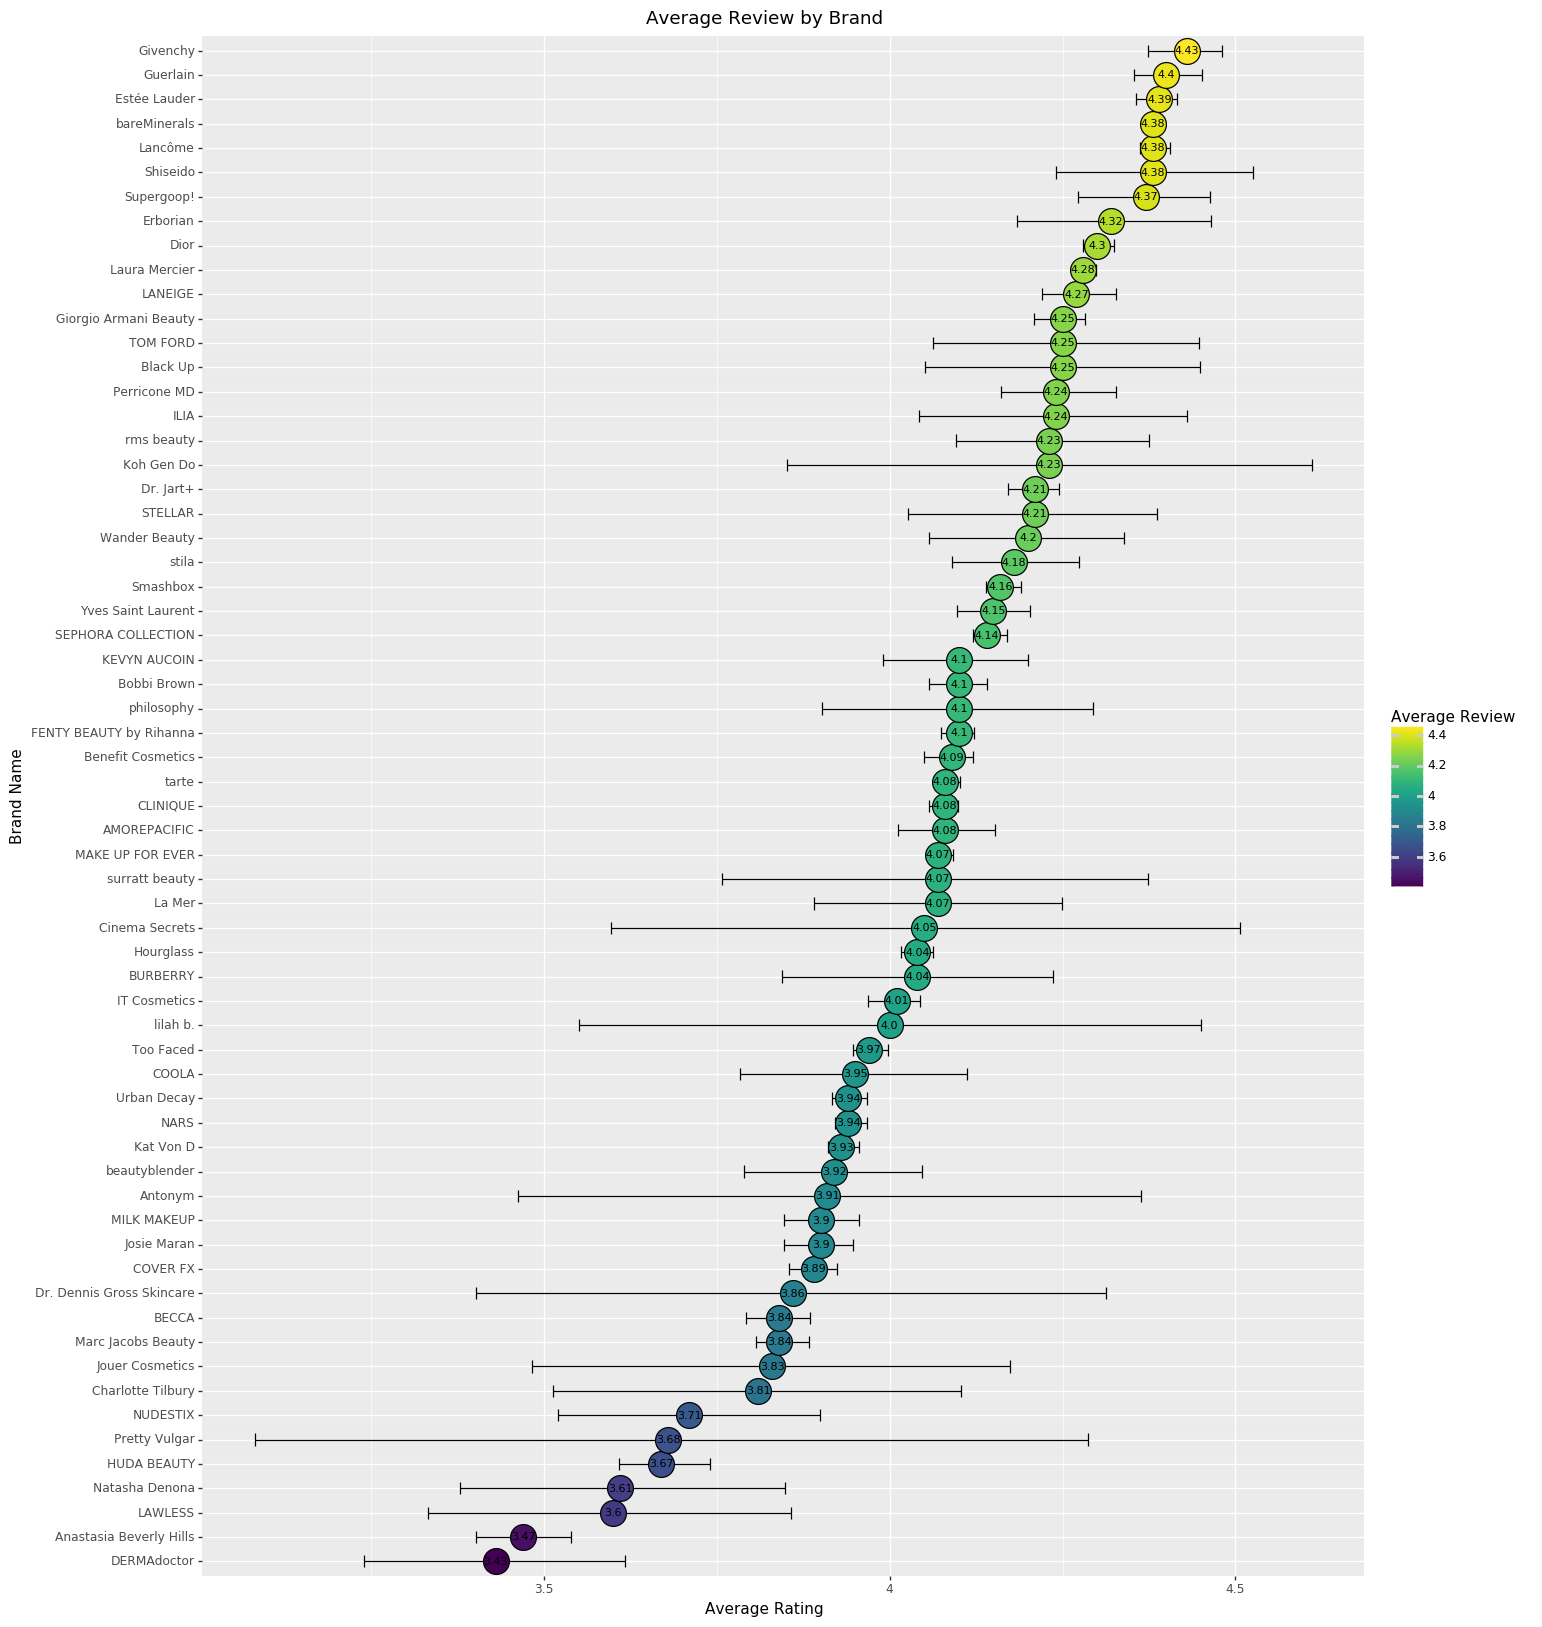

<ggplot: (138082391286)>

In [19]:
(p9.ggplot(brand_df, aes('brand', 'averageReview', label = 'averageReview', fill = 'averageReview')) + 
geom_errorbar(aes(ymin = 'lower_rating_lim', ymax = 'upper_rating_lim'), color = 'black') +
geom_point(stat = 'identity', size = 10) +
geom_text(color = 'black', size = 8) +
theme(figure_size = (15,20)) +
coord_flip() +
ggtitle("Average Review by Brand") + 
ylab('Average Rating') + 
xlab('Brand Name') + 
labs(fill = 'Average Review'))

The average review for foundation brand is show above. The lowest review at 3.4 (DERMADoctor),while the highest at 4.43(Givenchy).

It is interesting to see that most of "luxury"/expensive brands have the highest ratings. The highest rated foundations comes from Givenchy, Guerlain, Estee Lauder, and Lancome. Where brands which tend to targer the younger generation such as Urban Decay and Benefit Cosmetics tend to not do so well in average ratings.

A question which can be investigated is if ratings for luxury brands are inflated due to the customers wanting to like an expensive product. eg. If I spent 80 USD on a bottle of foundation, it is very possible that I am less willing to criticize the foundation simply becuase of the hefty price spent of the product. This could be explored in a correlation between price and ratings, as well some do some sort of sentiment analysis of the text of reviews for all the foundations. 

Also Bare Minerals seems to do very well in average ratings despite having well over 35,000 reviews. 

The black bar aroud the points represent the 95th percent confidence intervals for the average products. This is included as it willl allow us to visually see the "confidence" we can have on these average reviews. If a brand has a wide confidence interval, it would indicate that the brand had less reviews and therefore why the interval is larger, thus the average reviews is less trustworthy. If a brand has a small confidence interval eg. Bare Minerals, it would indicate that we can trust that the products from Bare Minerals will generally be highly rated. 

### Average Foundation Price by Brand

In [20]:
brands = list(df['brand'].unique())
avg_reviews = [round(df[df['brand'] == i]['rating'].mean(),2) for i in brands]
count = df['brand'].value_counts()
brand_df = pd.DataFrame({'brand' : brands, 'averageReview' : avg_reviews, 'Count' : count}).reset_index(drop = True)

#find average price of each brand and add to brand_df
brand_df['average_price'] = [round(df[df['brand'] == i]['price'].mean(),4) for i in brand_df['brand']]

#reorder brand_df into descending order based on average price
brand_order = brand_df.sort_values('average_price').reset_index(drop = True)['brand']
brand_df['brand'] = pd.Categorical(brand_df['brand'], categories = brand_order, ordered = True)

C:\Users\Jackson\Anaconda3\lib\site-packages\plotnine\layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


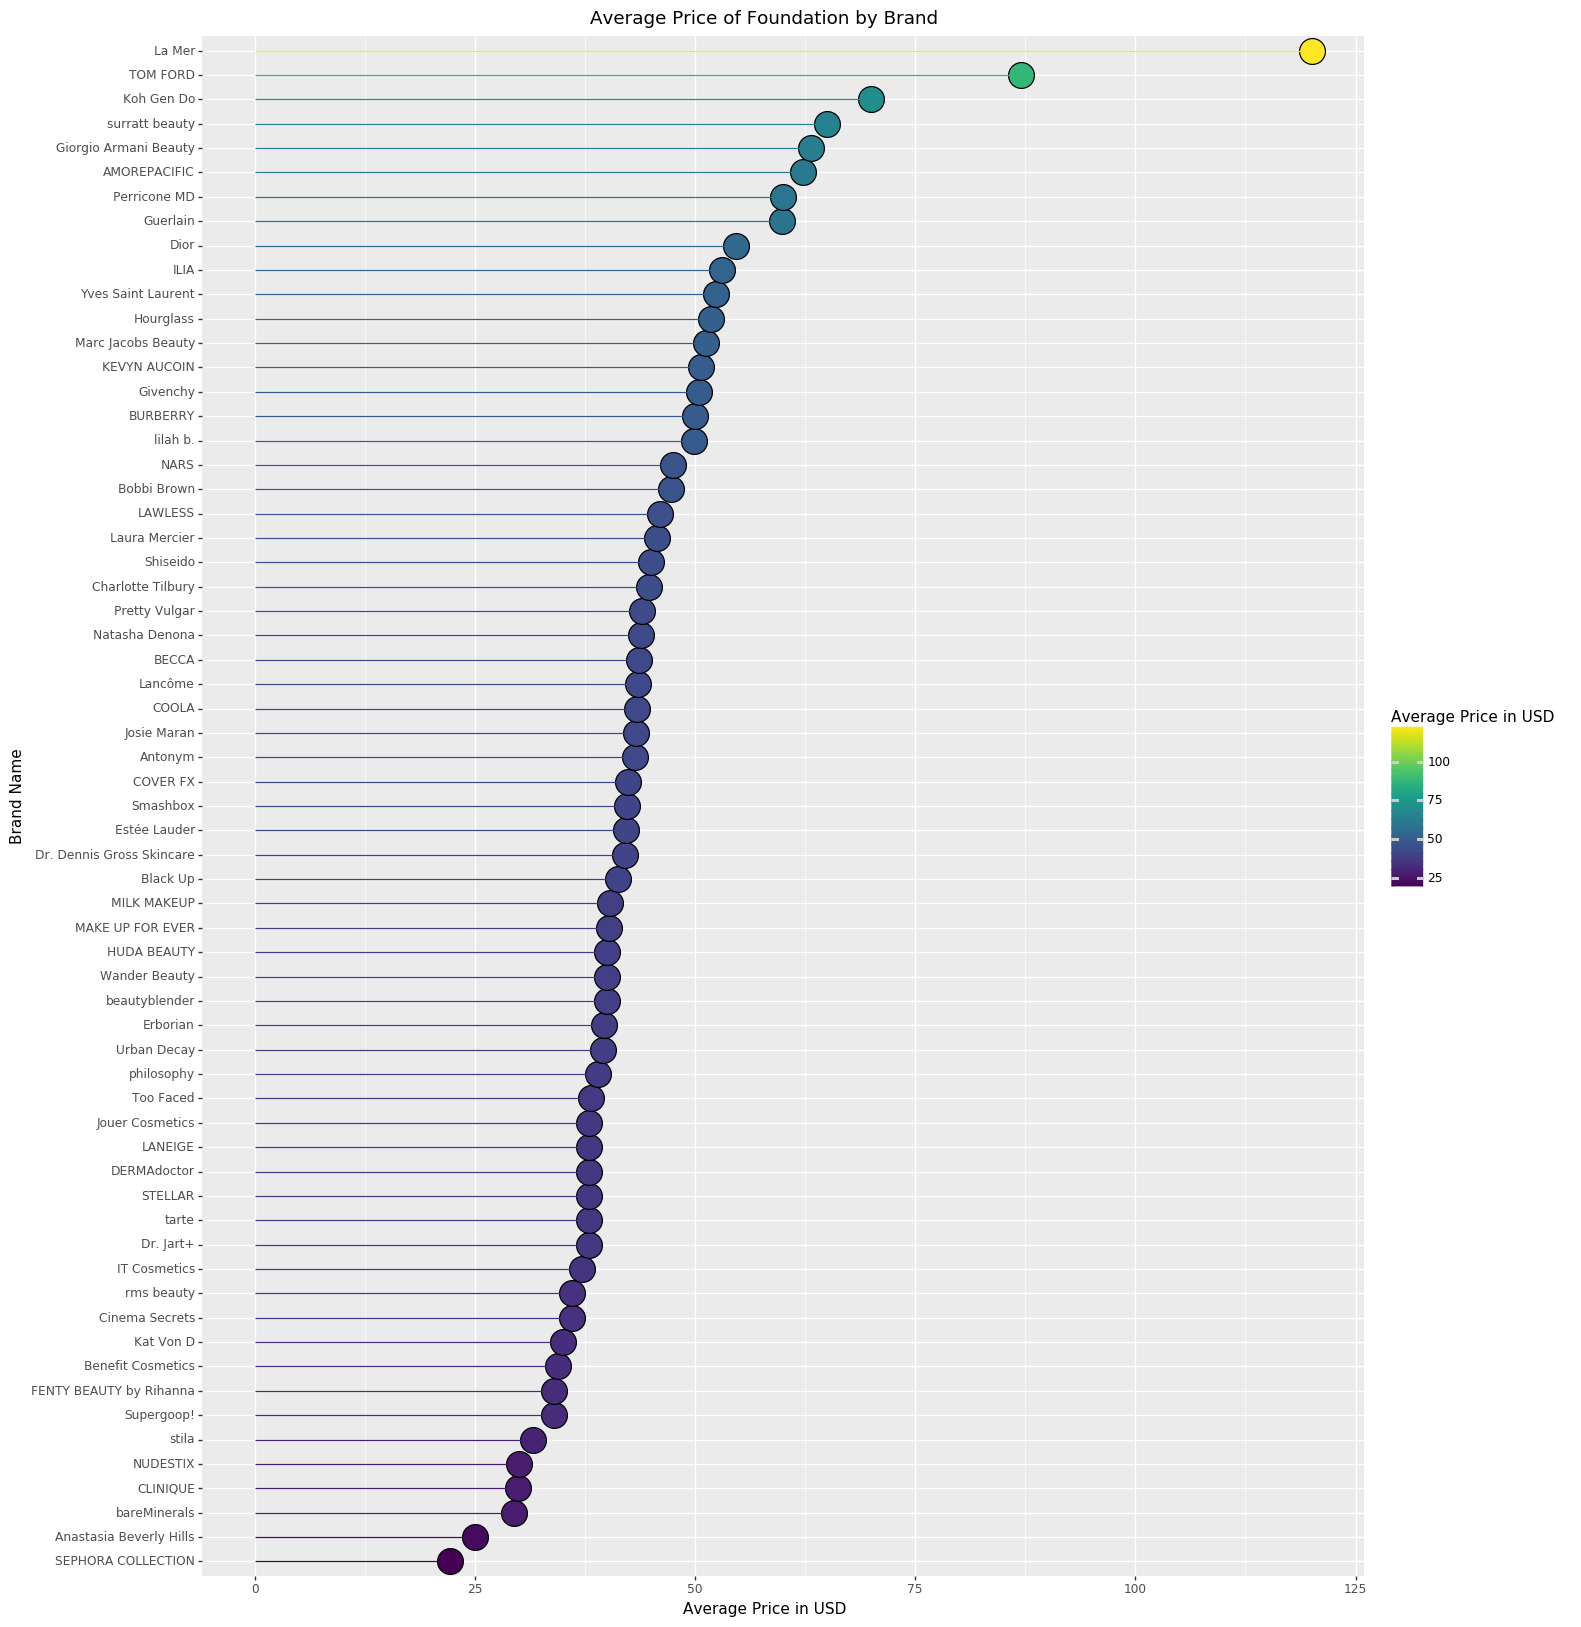

<ggplot: (-9223371898771560823)>

In [21]:
(p9.ggplot(brand_df, aes('brand', 'average_price', label = 'average_price', fill = 'average_price')) +
geom_point(stat = "identity", size = 10) +
geom_segment(aes(y=0, x = 'brand',
                yend = 'average_price', xend = 'brand',
                color = 'average_price')) +
theme(figure_size = (15,20)) +
coord_flip() + 
ggtitle("Average Price of Foundation by Brand") +
ylab('Average Price in USD') + 
xlab('Brand Name') +
labs(fill = 'Average Price in USD', color = "Average Price in USD"))

We can also look into the relationship between brands and price. Obviously, luxury brands like Tom Ford & La Mer have average prices of over 100 US per product. Bare Minerals seems to have a low average cost compared to other brands. with Sephora's own collection having the lowest average cost. 

##### Average Price of Brand in relation to its Average Rating

as mentioned above, we wanted to test if higher prices generally meant a higher review

In [22]:
### Adding to brand_df
brand_df['image_path'] = [df[df['brand'] == i].iloc[0]['brand_image_url'] for i in brand_df['brand']]

def read_img(url):
    """Returns image for each url link to image"""
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    return img

#add column to brand_df that finds every image for brand
brand_df['image'] = [read_img('https://www.sephora.com' + i) for i in brand_df['image_path']]

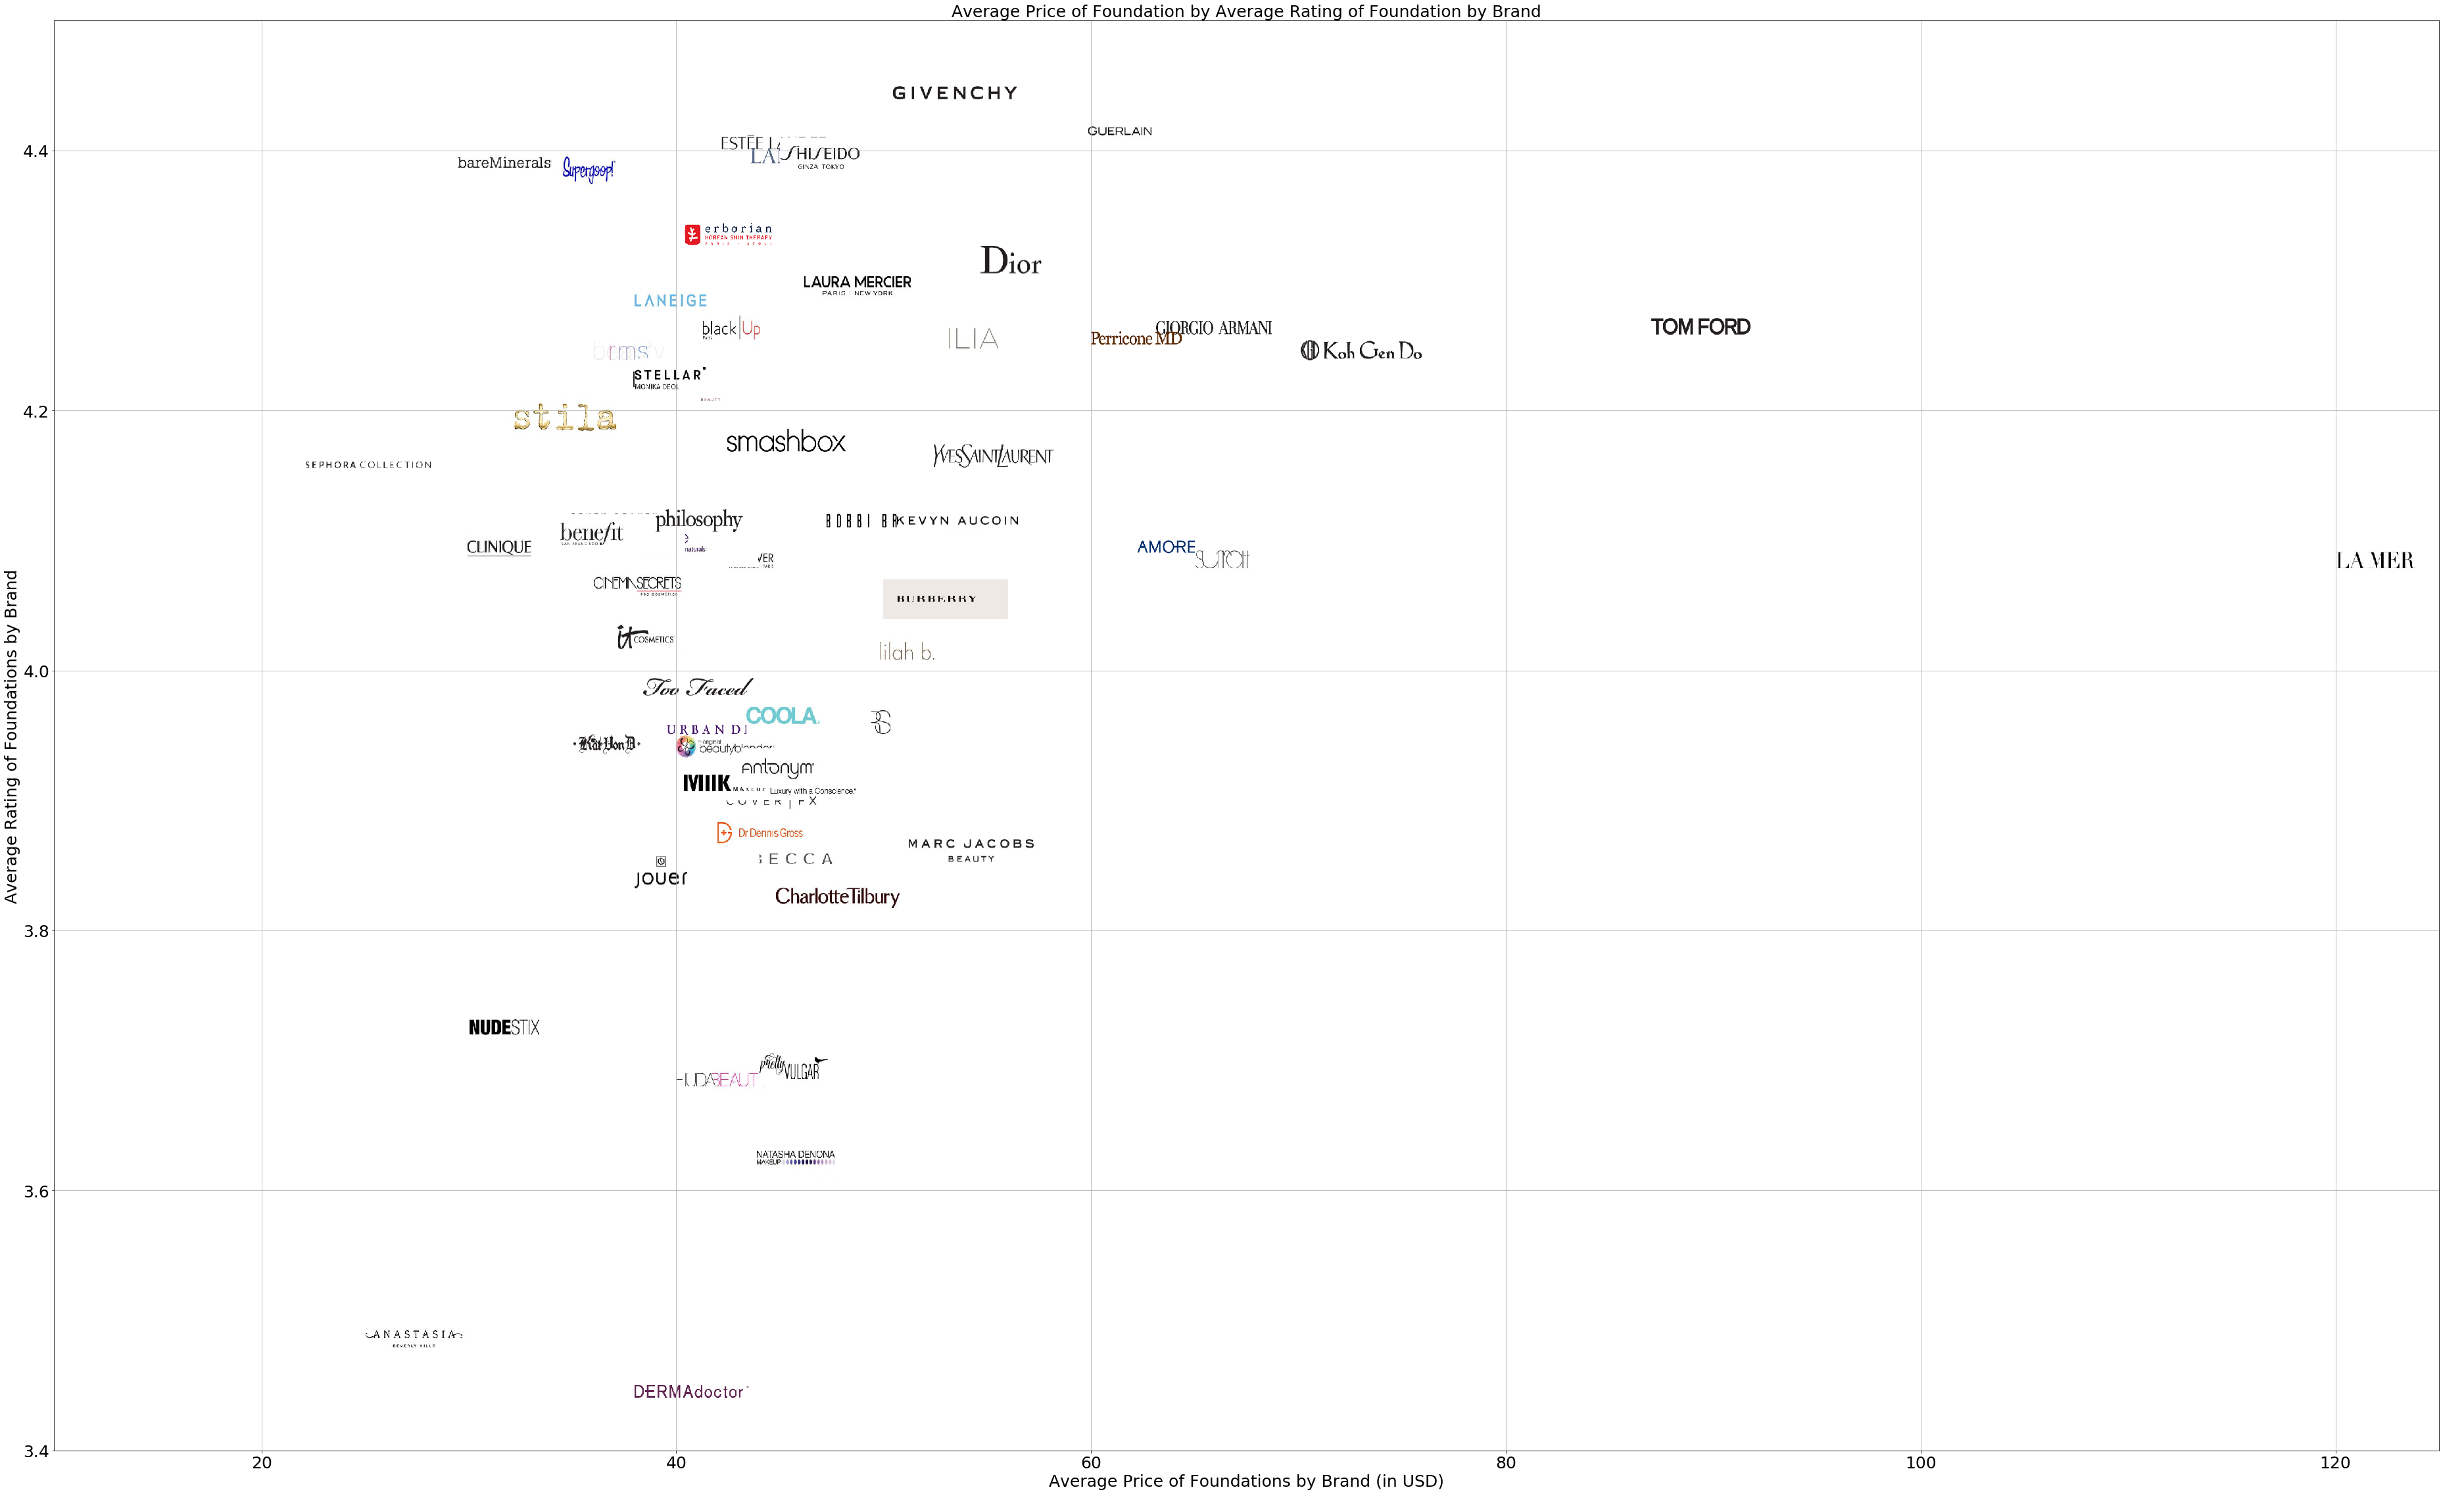

In [23]:
### Plotting
fig = plt.figure()
ax = fig.add_subplot(111)
def plotImage(x, y, im):
    
    """Returns point on plot with x,y coordinates and img for point"""
    
    bb = Bbox.from_bounds(x,y,6,0.03)  
    bb2 = TransformedBbox(bb,ax.transData)
    bbox_image = BboxImage(bb2,norm = None,origin=None,clip_on=False)

    bbox_image.set_data(im)
    ax.add_artist(bbox_image)

#plot point for every row in brand_df
for i,j,k in zip(brand_df['average_price'], brand_df['averageReview'], brand_df['image']):
    plotImage(i,j,k)
    
ax.set_ylim(3.4,4.5)
ax.set_xlim(10,125)
ax.set_title('Average Price of Foundation by Average Rating of Foundation by Brand', fontsize = 25)
ax.tick_params(axis='both', labelsize = 25)
ax.set_xlabel('Average Price of Foundations by Brand (in USD)', fontsize = 25)
ax.set_ylabel('Average Rating of Foundations by Brand', fontsize = 25)
plt.gcf().set_size_inches(65,40)
plt.grid(b=True, axis='both')

From the plot is it clear that there is no relationship between average prices and average rating. Most of the brands seem to concentrate bewtween 30 - 60 USD, with a few brands such as Tom Ford & La Mer breaking apart from this trend. You'll notice in the grouping that higher end brands have a higher concentration in the top right. This could indicate that there is a very weak correlation for a subset of products.

### Reviewer Characterisitcs Utilization

In this section, we will use the information reviewers have provided about themselves and their experience with the products

##### Skin Type

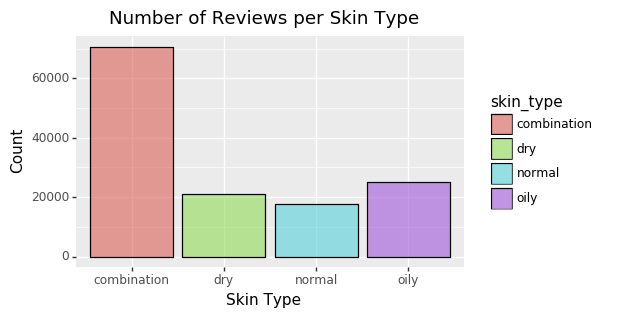

<ggplot: (-9223371898772504625)>

In [24]:
skin_type_db = df[~df['skin_type'].isna()]
(p9.ggplot(skin_type_db, aes('skin_type', fill = "skin_type")) +
geom_bar(color = 'black', alpha = 0.6) +
theme(figure_size = (5,3)) +
ggtitle("Number of Reviews per Skin Type") +
xlab("Skin Type") +
ylab("Count"))

The majority of the reviews are written by people who have a "combination" skin type, meaning both dry and oily. This could be due to skin types fluctuating over time, changing from dry to oily depending on the weather/season. Also it is possible beucase when people are asked to identify their skin type, it can be difficult to categories it as one or another. Therefore they could resort to *combination* to encompass all skin types 

In [25]:
skin_concern = df[~df['skin_concerns'].isna()]
skin_concern = skin_concern[~skin_concern["age"].isna()]
skin_concern = skin_concern[["skin_concerns", "age"]]

skin_age_group = skin_concern.groupby(["skin_concerns", "age"]).size().reset_index(name = 'count')
skin_age_group = pd.merge(skin_age_group, skin_concern.groupby(['age']).size().reset_index(name = 'total')[['age','total']],on = 'age')
skin_age_group['count'] = (skin_age_group['count']/skin_age_group['total'])
skin_age_group = skin_age_group.drop(columns = ['total'])

take_out = ['cellulite', 'calluses', 'cuticles', 'strechMarks']
skin_age_group = skin_age_group[~(skin_age_group["skin_concerns"].isin(take_out))]

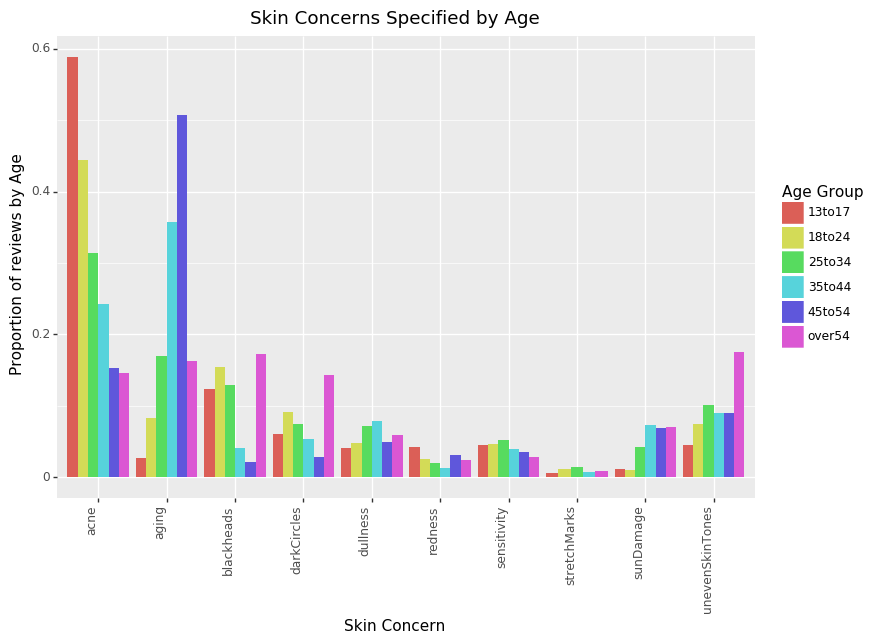

<ggplot: (137975855708)>

In [26]:
(p9.ggplot(skin_age_group, aes('skin_concerns','count')) +
geom_bar(aes(fill = 'factor(age)'), stat = 'identity', position = 'dodge') +
theme(figure_size = (9,6)) +
theme(axis_text_x = element_text(rotation = 90, hjust = 1)) +
ggtitle('Skin Concerns Specified by Age') +
ylab('Proportion of reviews by Age') +
xlab('Skin Concern') +
labs(fill = 'Age Group'))

In this plot, we can see how skin concerns vary with age. We see that for most girls between 13 to 24, acne is the biggest issue for thier skin, and drops consistently as the age groups gets older. It also seems that skin aging is a issue that becomes a concern as you get older. However, it is interesting to see that this drops drastically after 54. It seems that the skinaging what women between 45 to 54 worry about most. For women over 54 their top concerns about their skin is blackheads, dark circles and uneven skintones.

### Skin Tone Distribution

In [27]:
#create new df for skin tone with no nas 
skin = df[~df['skin_tone'].isna()]
skin = skin[["brand",'name','rating','skin_type','eye_color','skin_concerns','skin_tone','age','price','recommended']]

#assign numerical value to skin complexion for ranking
tone_val = {'porcelain' : 1, 'fair' : 2, 'light' : 3, 'medium' : 4, 'tan': 5, 'olive': 6, 'deep': 7, 'dark': 8, 'ebony':9}
skin['tone_val'] = pd.Series(skin['skin_tone'], index = skin.index)
skin = skin.replace({'tone_val': tone_val})

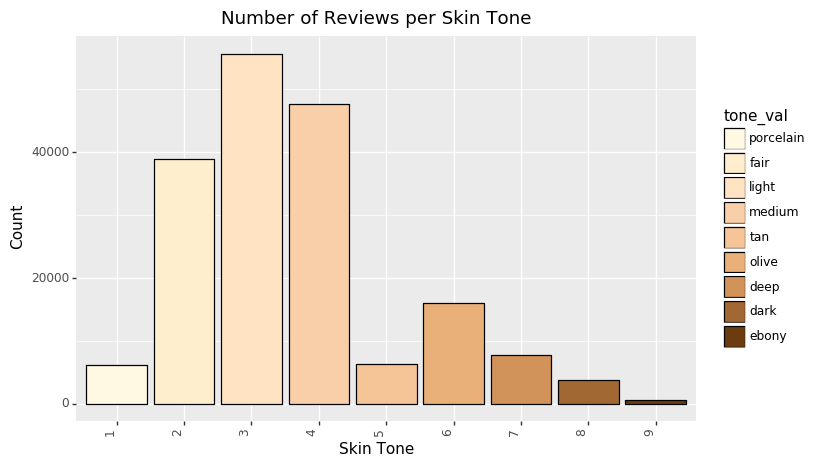

<ggplot: (137978431096)>

In [28]:
#Distributino of all skin tones
skin_palette = ["#FFF8E3", "#FFEECD", "#FFE3C3","#F9CFA9", "#F5C598", "#EAB07A", "#D1935A", "#A16834", "#6B3C10"]
skin['tone_val'] = skin['tone_val'].astype(str)

(p9.ggplot(skin, aes('tone_val', fill = 'tone_val')) +
geom_bar(color = 'black') +
theme(figure_size = (8,5)) +
theme(axis_text_x = element_text(rotation = 90, hjust = 1)) +
ggtitle("Number of Reviews per Skin Tone")+
ylab("Count")+
xlab("Skin Tone")+
scale_fill_manual(labels = list(tone_val.keys()), values = skin_palette))

The vast majority of reviewers fall into skin complexions between porcelian, fair, light and medium. There seems to be a lack of representation for those with deep, dark, ebony skin tones. This could possibly attributed to the lack of shade diversity among foundations. 

In [29]:
#subet the products that have over a hundred_reviews that provide skin tone
count = skin.groupby(['name']).size().reset_index(name = 'count')
skin100 = count[count['count'] >= 100]
skin100 = skin[skin['name'].isin(skin100['name'])]


In [30]:
brand_list = skin100['brand'].value_counts().index.tolist()
brand_cat = CategoricalDtype(categories = brand_list, ordered = True)
skin100['brand_cat'] = skin100['brand'].astype(str).astype(brand_cat)

C:\Users\Jackson\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


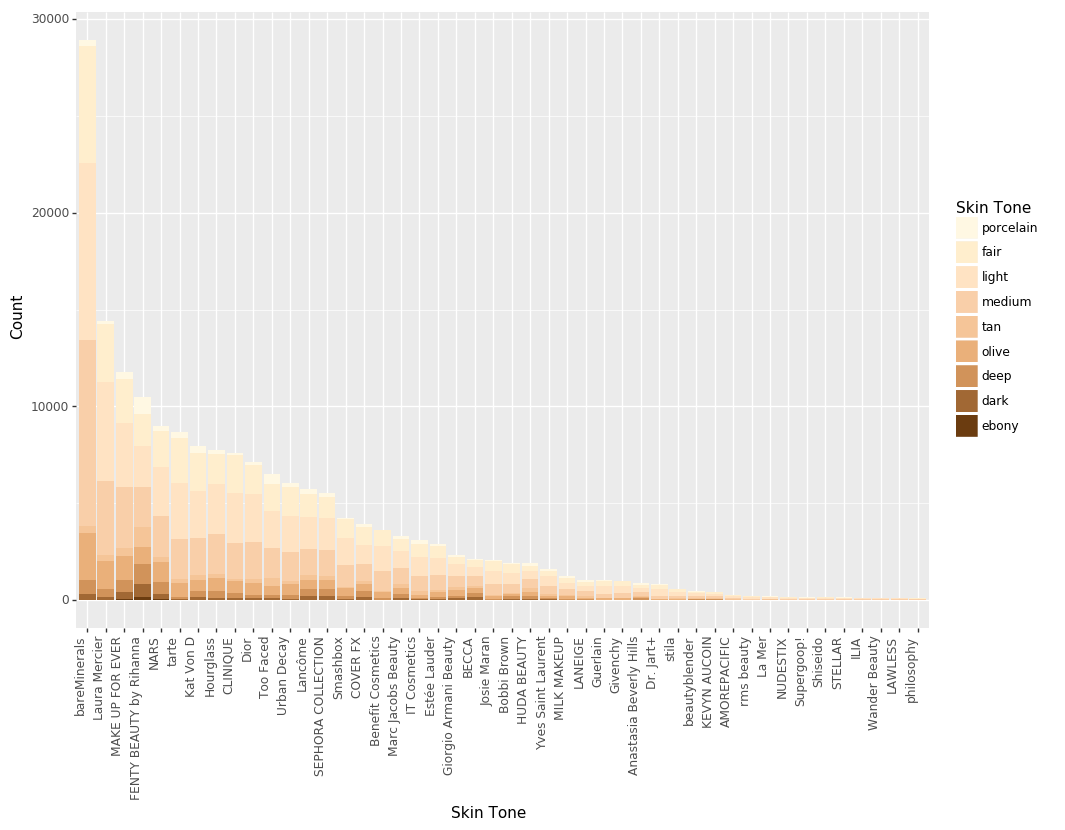

<ggplot: (137978431310)>

In [31]:
#company dist.
(p9.ggplot(skin100, aes('brand_cat', fill = 'tone_val')) +
geom_bar() +
theme(figure_size = (11,8)) +
theme(axis_text_x= element_text(rotation=90, hjust = 1))+
xlab('Skin Tone') +
ylab('Count') +
scale_fill_manual(labels = list(tone_val.keys()), values = skin_palette)+
labs(fill = 'Skin Tone'))

This plot only shows brand with at least 100 reviews with skin tone information. This plot provides further evidence that deep,dark, ebony skin tones are not well catered towards in the foundation department. You can see that most of the reviewers are in the lighter skin ranges, and barely any reviwers have darker skin tones. The only brand with any noticable ebony representation is FENTY Beauty. This is not surprising as FENTY did get alot of attention for have 40 different foundatoin shades when their first foundation debuted. Along with its owner Rihanna being a well known, it is not a surprise that Fenty attracts more darker skin tone users. 

This plot confirms that the general foundation market, particularly in the US is failing to create to products for dark skin tones, and seems to cater towards lighter skin women. 

### Distribution of Reviewers Skin Tone by Foundation(Top 5 companies)

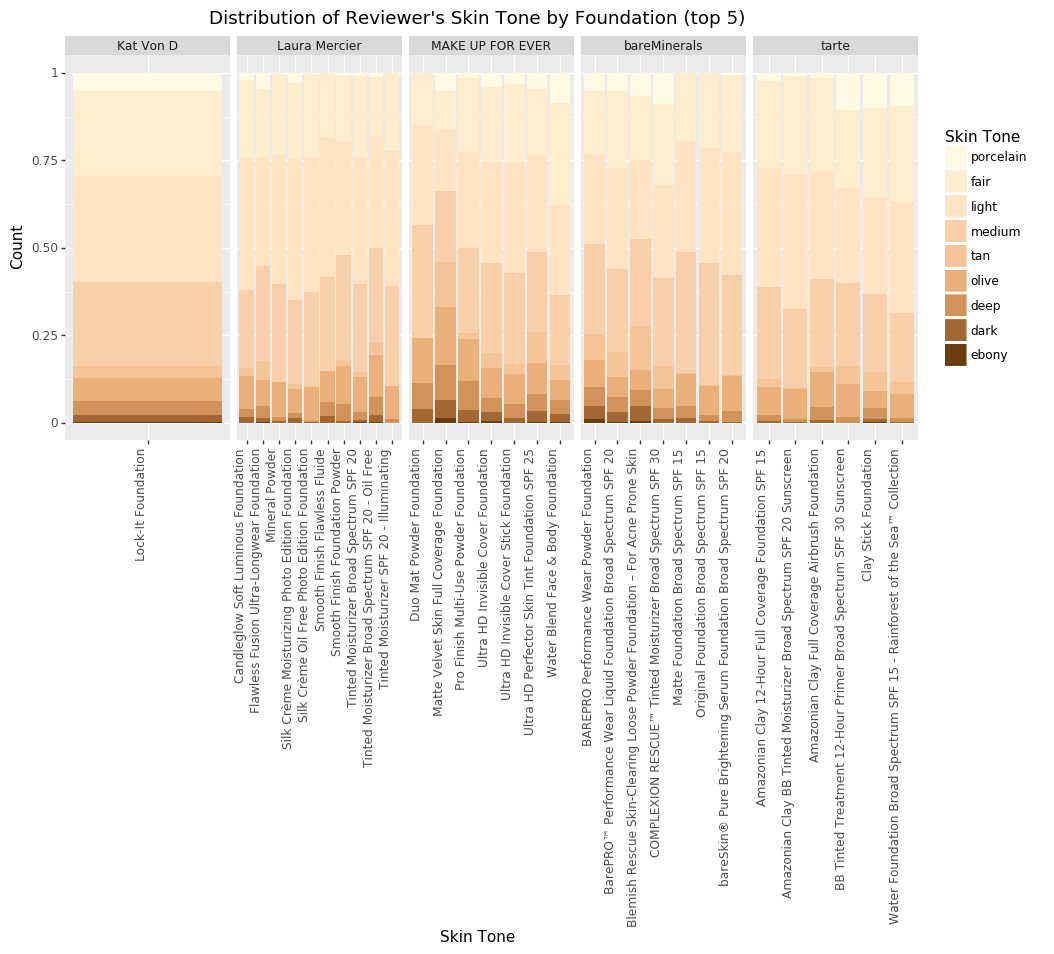

<ggplot: (-9223371898870771396)>

In [52]:
top_5_brands = skin100[skin100['brand'].isin(brand_list[0:5])]
top_5_brands = top_5_brands[['brand', 'name','tone_val']]

(p9.ggplot()+
geom_bar(top_5_brands, aes('name', fill = 'tone_val'), position = 'fill')+
theme(figure_size = (11,5)) +
theme(axis_text_x = element_text(rotation = 90, hjust = 1)) +
ggtitle ("Distribution of Reviewer's Skin Tone by Foundation (top 5)") +
xlab('Skin Tone') + 
ylab('Count') + 
scale_fill_manual(labels = list(tone_val.keys()), values = skin_palette) +
facet_wrap('~brand', scales = "free_x", nrow = 1) +
labs(fill = 'Skin Tone'))

Taking the top 5 foundations, we have foundations from Kat Von D, Laura Mercier, Make Up Forever, Bare Minerals and tarte. It is clear that most brands have a higher disparity of skin tones namely tarte and Bare Minerals. We can see that this proportion can be notable vary even within individual products of a brand. eg. for Make Up For Ever, as the skin tone goes darker so do the number of reviews, however *Matte Velvet Skin Full Coverage Foundation* seems to be an exception to this rule.


#### Age Distribution

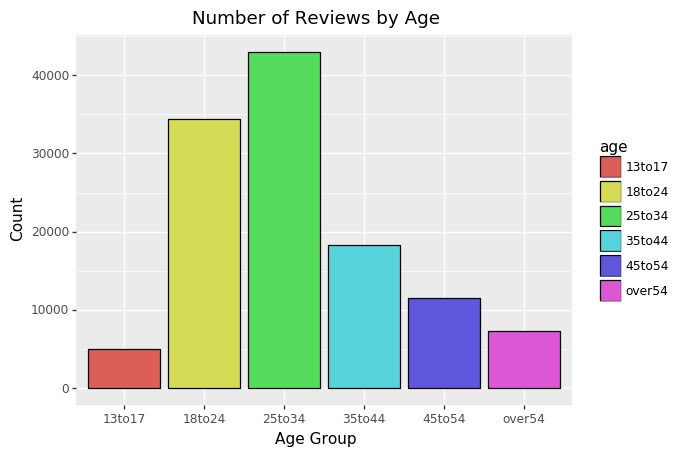

<ggplot: (138083024669)>

In [33]:
age_df = df[~df['age'].isna()]

(p9.ggplot(age_df, aes('age')) + 
geom_bar(aes(fill = 'age'), color = 'black') +
ggtitle('Number of Reviews by Age') +
xlab("Age Group") +
ylab("Count"))

The age group that reviews most of the foundations on Sephora is in the 25 to 34 age group, with well over 40,000 reviews. Followed by 18 to 24 year old group with close to 35,000 reviews. It seems the 13 to 17 year group and over 54 put down reviews on Sephora the least.  

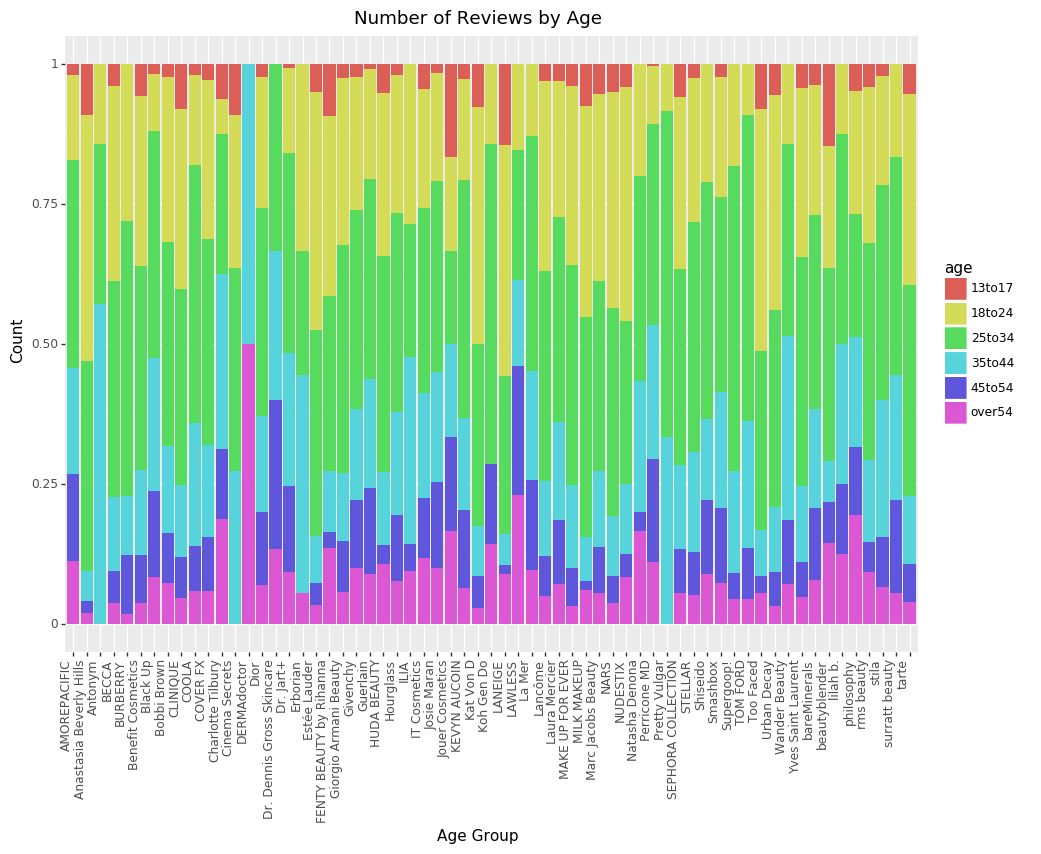

<ggplot: (137977572728)>

In [34]:
(p9.ggplot(age_df, aes('brand', fill = 'age')) +
geom_bar(position = 'fill') + 
ggtitle('Number of Reviews by Age') +
xlab('Age Group')+
ylab('Count')+
theme(axis_text_x = element_text(rotation = 90, hjust = 1))+
theme(figure_size = (11,8)))

From this plot we can see that most women over 54 use DERMADoctor, whereas Antoym and Pretty Vulgar have 0 reviews from this age group. From this plot we can determine that women over 54 prefer DERMADoctor, Philophy and LawLess.

While women between 13 to 17 prefer Jouer Cosmetics, Laneige and Beauty Blender.

It is very clear from this graph that brands have different customer bases that are partially based on age. This supports the fact that most brands try to target specific makrets when they create their products. However, that is not to say that the brands listed here target the age groups they desired. 

### Where are People reviewing products 

In [53]:
# requires plotly
'''
location_db = df[~df['location'].isna()]
location_db['location'] = location_db['location'].astype(str)

#seperate city and state
new = location_db['location'].str.split(",", n = 1, expand = True)
location_db['city'] = new[0]
location_db['state'] = new[1]

#remove entries that do not have a state
location_db = location_db[~location_db['state'].isna()]
location_db = location_db[location_db['state'].map(len) == 2]
location_db['state'] = location_db['state'].str.upper()

#remove entries that arent states in the US
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

location_db = location_db[location_db['state'].isin(states)]
location_df = location_db.groupby(['state']).size().reset_index(name = 'count')

data = [dict( type = 'cloropleth', locations = location_df['state'], z = location_df['count'].astype(float), locationmode = 'USA-states',
            marker = dict(color = 'rgb(255,255,255)', width = 2)), colorbar = dict(title = "Number of Reviews")]
layout - dict( title = 'Number of Reviews by State', geo = dict(scope = 'usa', projection = dict(type = 'albers usa'), showlakes = True, lakecolor = 'rgb(255,255,255)'))

fig = dict(data = data, layout = layout)
plotly.plotly.iplot(fig,filename = d3-coloropleth-map)
'''

'\nlocation_db = df[~df[\'location\'].isna()]\nlocation_db[\'location\'] = location_db[\'location\'].astype(str)\n\n#seperate city and state\nnew = location_db[\'location\'].str.split(",", n = 1, expand = True)\nlocation_db[\'city\'] = new[0]\nlocation_db[\'state\'] = new[1]\n\n#remove entries that do not have a state\nlocation_db = location_db[~location_db[\'state\'].isna()]\nlocation_db = location_db[location_db[\'state\'].map(len) == 2]\nlocation_db[\'state\'] = location_db[\'state\'].str.upper()\n\n#remove entries that arent states in the US\nstates = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", \n          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", \n          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", \n          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", \n          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]\n\nlocation_db = location_db[location_db[\'state\'].isin(states)]\nlocation_df = lo

### When are People reviewing Products

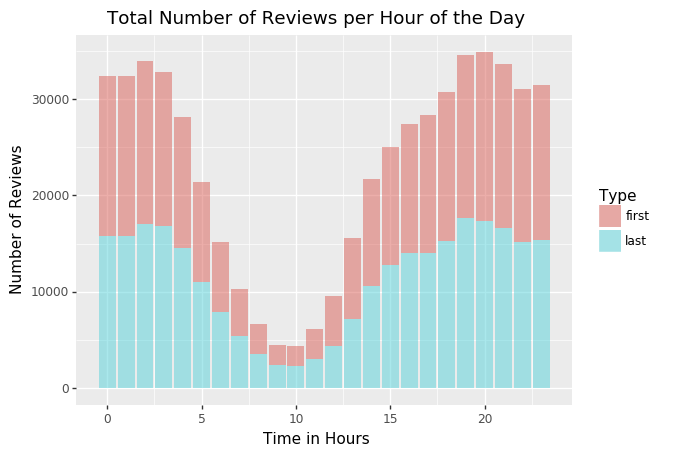

<ggplot: (-9223371898876698245)>

In [36]:
#get hours as integers
df['submission_hour'] = [int(df['first_submission_date'][i][11:13]) for i in range(len(df['first_submission_date']))]
df['last_mod_hour'] = [int(df['last_submission_date'][i][11:13]) for i in range (len(df['last_submission_date']))]

#new data frame for plotting
time = df['submission_hour']
time = time.append(df['last_mod_hour'])

sub_type = ['first']*len(df) + ['last']*len(df)
time_df = pd.DataFrame({'Type': sub_type, 'Time': time})

(p9.ggplot(time_df,aes('Time'))+
geom_bar(aes(fill = 'Type'), alpha = 0.5) +
ggtitle('Total Number of Reviews per Hour of the Day') +
xlab('Time in Hours') +
ylab('Number of Reviews'))

The majority of people, whether they are reviewing a product for the first time, or updating an old review, post on Sephora between midnight to 4 and after 7:00pm. The dip follows consistenly with a typical 8 hour work day, which suggest most people review products when they get home and have free time to do so.

### Analyzing the Tags Data

Sephora provides us with tags data in their API. Each tag is found in a review and have counts. Thus, we can search for words that pertain more to foundation information rather thatn non-informative words such as "great","fantastic".

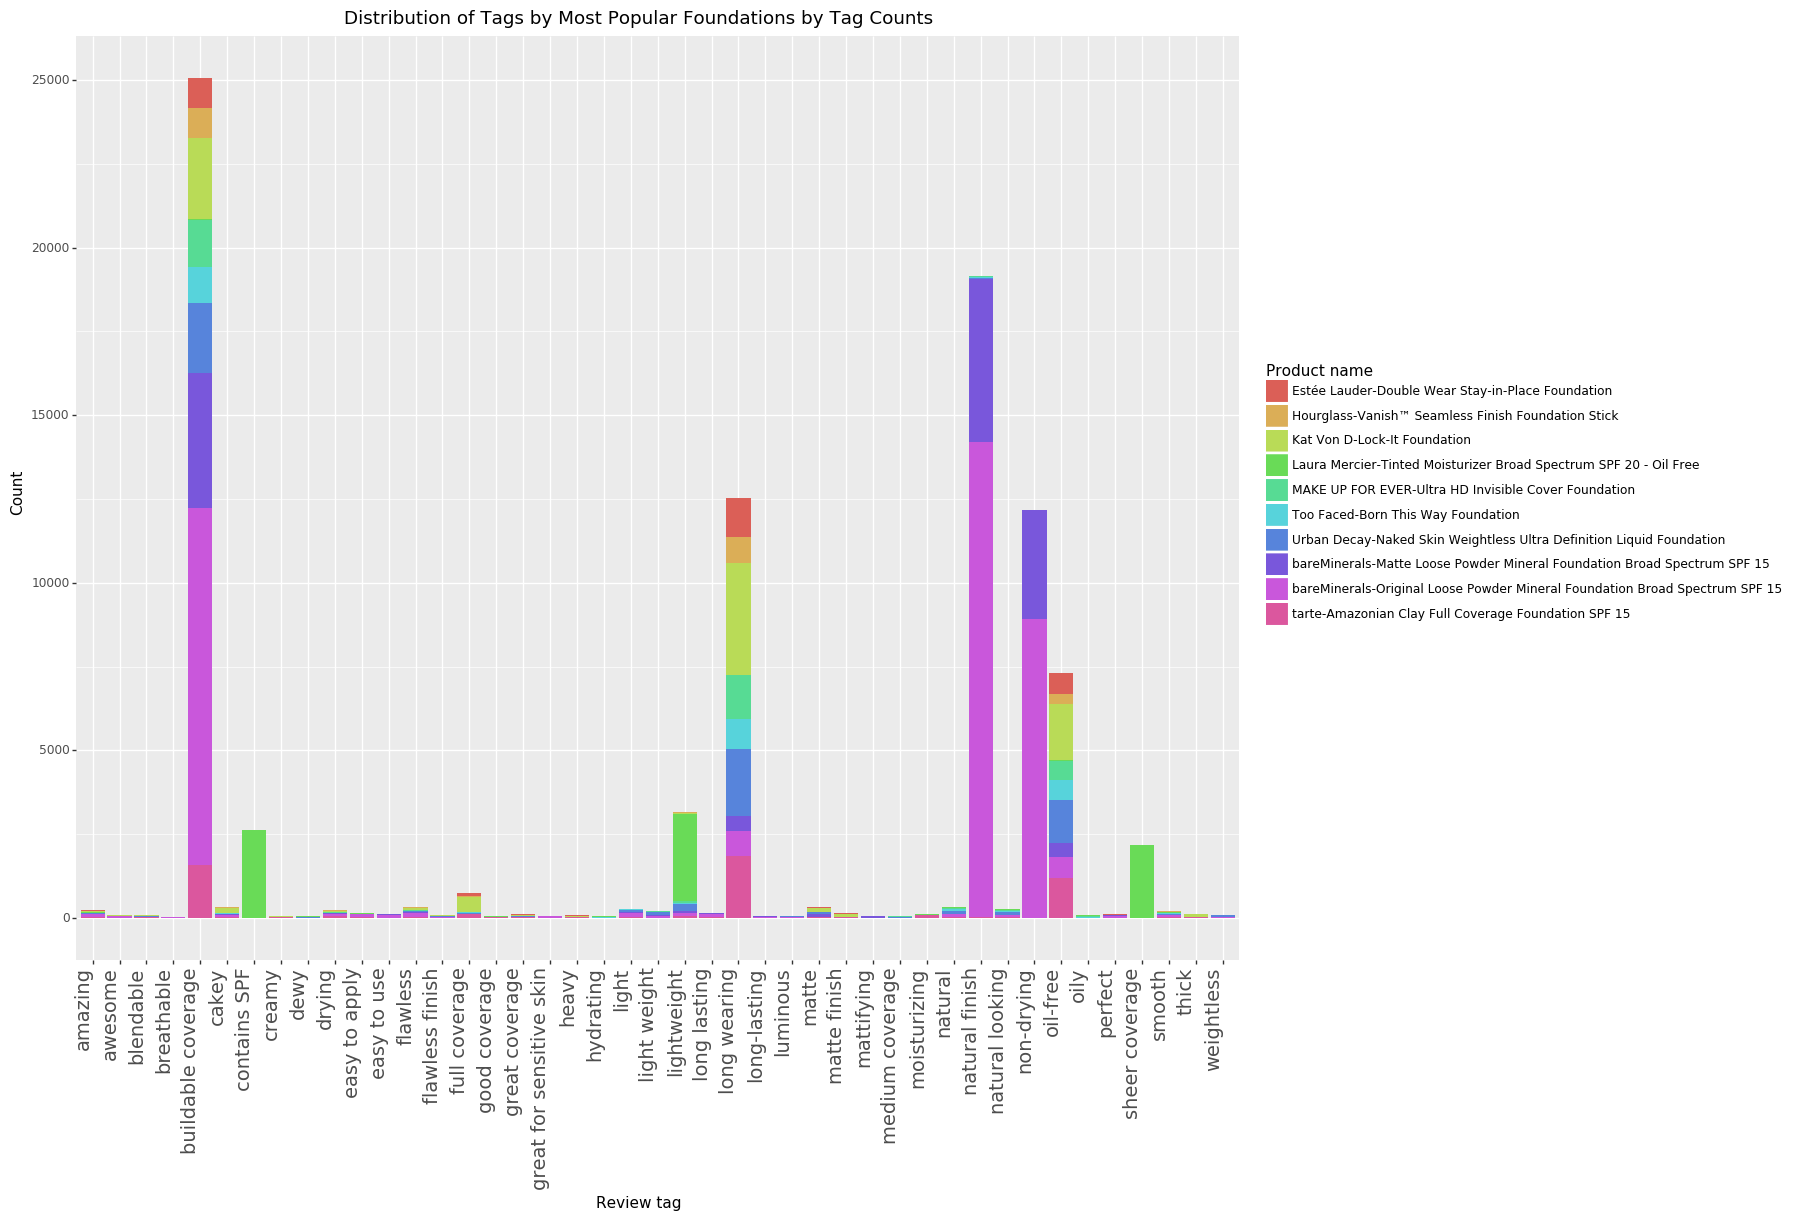

<ggplot: (137978086036)>

In [37]:
tags_df = pd.read_csv('Sephora_Foundation_Tags.csv')

most_pop_foundation_tags = tags_df[tags_df['total_review_count'] > 5000 ]

total_count = [sum(most_pop_foundation_tags[most_pop_foundation_tags['Value'] == i]['Count']) for i in most_pop_foundation_tags["Value"].unique()]
total_count_df = pd.DataFrame({'Tag' : most_pop_foundation_tags['Value'].unique(), "Count": total_count})

total_count_df_high = total_count_df[total_count_df['Count'] > 30]

most_pop_foundation_tags = most_pop_foundation_tags[most_pop_foundation_tags['Value'].isin(total_count_df_high['Tag'])]

tags = most_pop_foundation_tags["Value"].unique()
tags = [i for i in tags if sum(most_pop_foundation_tags[most_pop_foundation_tags['Value'] == i]['Count']) > 100]

most_pop_foundation_tags['product_name'] = most_pop_foundation_tags['brand'] + '-' + most_pop_foundation_tags['product']

(p9.ggplot(most_pop_foundation_tags, aes('Value', 'Count', fill = 'product_name')) +
geom_bar(stat = 'identity') +
theme(axis_text_x = element_text(rotation = 90, hjust = 1)) +
theme(figure_size = (15,12)) + 
ggtitle('Distribution of Tags by Most Popular Foundations by Tag Counts') + 
theme(axis_text_x = element_text(size = 14)) +
xlab("Review tag") + 
labs(fill = 'Product name'))

To get an idea of what were the most popular tags in reviews, I took the foundation that had at least 5000 total counts for all of their tags and plotted them. The most common tags were "Buildable coverage", "long wearing', "natural finish', 'non drying' and 'oil free'. Although four of the foundations in this plot have SPF 15, only Laura Mercier's foundation contains SPF 20, which would indicate why "contains SPF" cloumns is so low. Laura Mercier's foundation is also tagged in 'lightweight' and 'sheer coverage'.

The tags with the highest number of foundations represented are "buildable coverage" , "long wearing', 'oil free'. This is probably becuase these are some of the key features of a good foundation. If it cannot be built upon, nobody will buy the foundation. Similarly, nobody wants to clog up their pores with oil.

While it is definelty interesting to look at this data, it will not be used in the predictive model. This is because while we have tags, we do not have any context how the reviewers used/selected the tags. eg. if a product was given a 'oily' tag there is no way of knowing whether the reviewer was saying the oily or not oily, the review api only picked up 'oily'. This is particulary confusing becuase the some products have both 'oily' and 'oil free' tag.

### Statistical Test

C:\Users\Jackson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Jackson\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


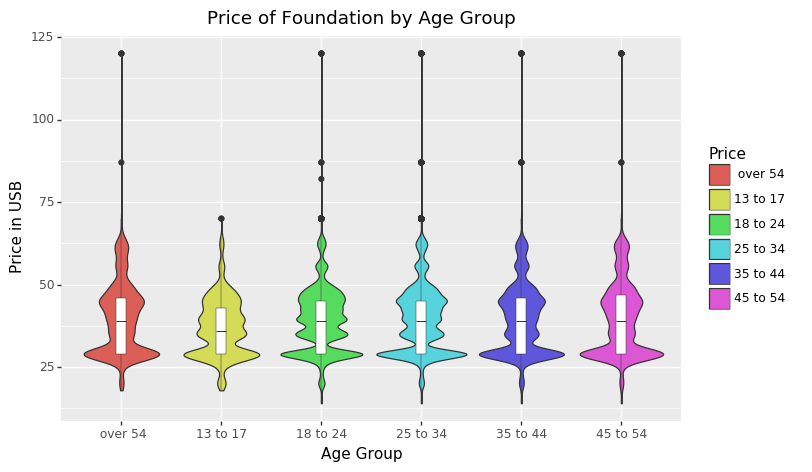

<ggplot: (137977563796)>

In [39]:
dat = df.dropna(subset=['age'])
dat['age'] = [i.replace('to', ' to ') for i in dat['age']]
dat['age'] = [i.replace('over', ' over ') for i in dat['age']]

(p9.ggplot(dat, aes('age','price')) + 
 geom_violin(aes(fill = 'age')) +
 geom_boxplot(width = 0.1, size = 0.2) + 
 theme(figure_size = (8,5)) +
 ggtitle("Price of Foundation by Age Group") +
 ylab("Price in USD") + 
 xlab("Age Group") + 
 labs(fill = "Price"))

In the plot above, we see a much clearer difference between groups. Each group represents an age group.

Customers between 13 and 17 generally stick with products around the 25 dollar range, and stay away from any products over 50 dollars. Customers over 45 tend to review more expensive products. Regardless of age, it seems that most consumers buy foundations in the 30 dollar range.

In [40]:
#ANOVA TEST

mod = ols('price ~ age', data = dat).fit()

aov_table = sm.stats.anova_lm(mod,typ =2)
aov_table

,sum_sq,df,F,PR(>F)
age,3.379469e+04,5.0,68.797829,4.390487e-72
Residual,1.174638e+07,119564.0,NaN,NaN


The ANOVA test confirms the conclusions we got from the plot. The null hyptothesis was that the average price of foundation between age groups is the same. The alternative hypothesis is that at least one of the age groups has a different average pirce of foundation than the rest.

With the P-Value being basically 0, we can reject the null hypothesis and conclude that the average foundation price differs between age. Hence, there is a relationship between age group and price of foundation.

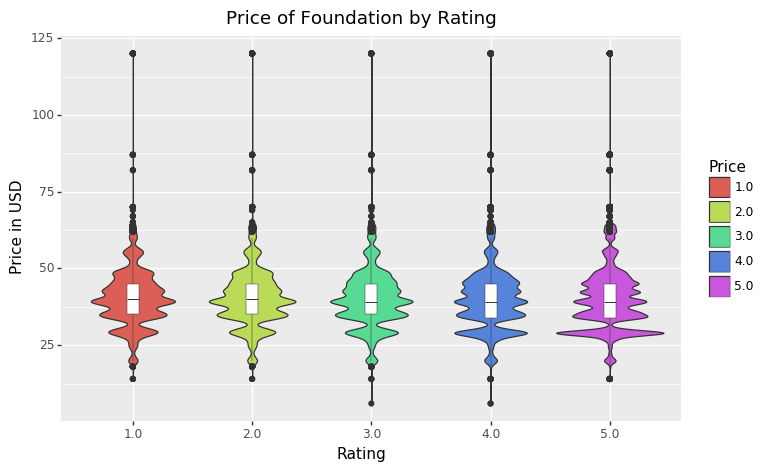

<ggplot: (137994694653)>

In [54]:
#convert ratings back to str
df['rating'] = df['rating'].astype(str)

(p9.ggplot(df, aes('rating','price')) + 
 geom_violin(aes(fill = 'rating')) +
 geom_boxplot(width = 0.1, size = 0.2) + 
 theme(figure_size = (8,5)) +
 ggtitle("Price of Foundation by Rating") +
 ylab("Price in USD") + 
 xlab("Rating") + 
 labs(fill = "Price"))

From this plot, it is hard to see if there are any major differences between the ratings. The groups all seem to follow similar distribution in terms of price and that is most likely becuase we only have 217 products, while having well over 270,000 reviews. 

the ANOVA test will help us better distinguish any differences in the price of foundation based on ratings. 
The null hypothesis was that the average price of foundation of all groups of ratings are the same. Our alternative hypothesis is that at least one of the ratings is different in its average price.

In [44]:
#ANOVA TEST

mod = ols('price ~ rating', data = dat).fit()

aov_table = sm.stats.anova_lm(mod,typ =2)
aov_table

,sum_sq,df,F,PR(>F)
rating,2.206952e+04,1.0,224.424551,1.089942e-50
Residual,1.175811e+07,119568.0,NaN,NaN


as expected the ANOVA test shows that we can reject the null hypothesis and thus conlcue that there are differences within groups of ratings, meaning that there is no relationship between rating of a foundation and the price of a foundation, and hence they are independent of one another.

### Correlation Matrix

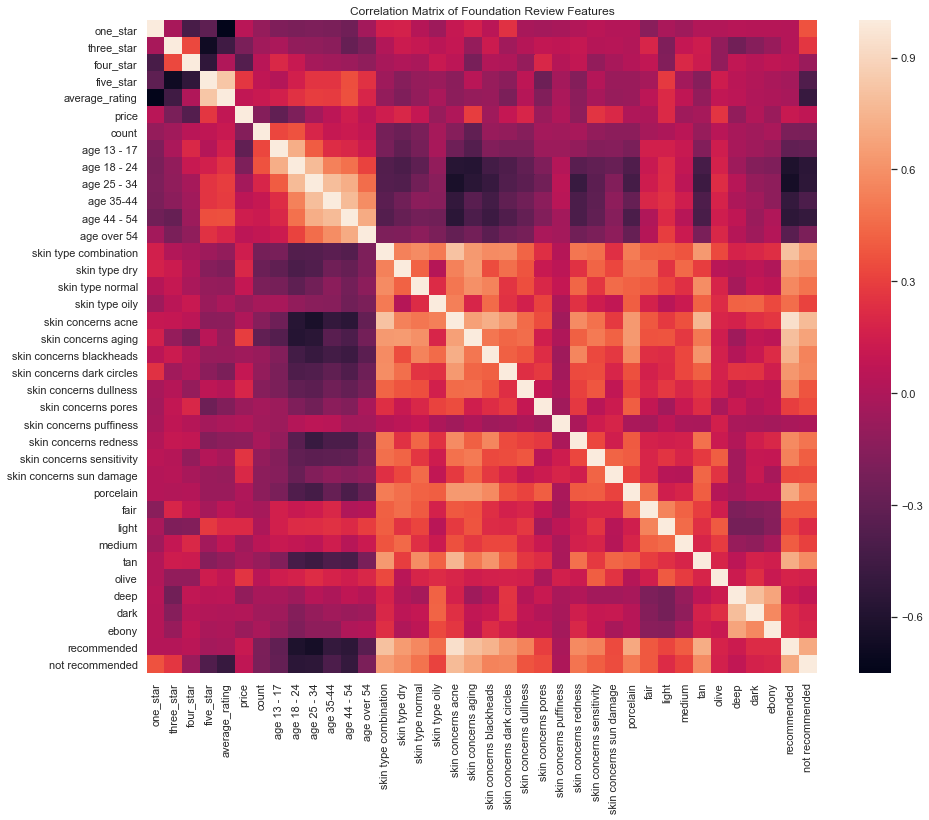

In [46]:
#convert rating column back to integer for averaging
df['rating'] = df['rating'].astype(float)

#proportions
one_star = []
two_star = []
three_star = []
four_star = []
#dummy variable drop
five_star = []

#average of total ratings
average_rating = []

#price given
price = []

#total number of reviews
count = []

#proportion
prop_rec = []
prop_not_rec = []
prop_no_rec = []

age13to17 = []
age18to24 = []
age25to34 = []
age35to44 = []
age45to54 = []
ageover54 = []
#dummy variable drop
no_age_given = []

skin_type_combination = []
skin_type_dry = []
skin_type_normal = []
skin_type_oily = []
#dummy variable drop
no_skin_type = []

skin_concerns_sensitivity = []
skin_concerns_acne = []
skin_concerns_aging = []
skin_concerns_blackheads = []
skin_concerns_redness = []
skin_concerns_darkCircles = []
skin_concerns_dullness = []
skin_concerns_sunDamage = []
skin_concerns_unevenSkinTones = []
skin_concerns_pores = []
skin_concerns_puffiness = []

#dummy variable drop
no_skin_concerns = []

skin_color_porcelain = []
skin_color_fair = []
skin_color_light = []
skin_color_medium = []
skin_color_tan = []
skin_color_olive = []
skin_color_deep = []
skin_color_dark = []
skin_color_ebony = []
no_skin_color = []

#aggregate values above for each product in data frame
for i in df['name'].unique():
    data = df[df['name'] == i]
    #data = data[~(data['recommended'].isna())]
    
    one_star.append(len(data[data['rating'] == 1])/len(data))
    two_star.append(len(data[data['rating'] == 2])/len(data))
    three_star.append(len(data[data['rating'] == 3])/len(data))
    four_star.append(len(data[data['rating'] == 4])/len(data))
    five_star.append(len(data[data['rating'] == 5])/len(data))
    
    average_rating.append(data['rating'].mean())
    
    price.append(data.iloc[0]['price'])
    
    count.append(len(data))
    
    prop_rec.append(len(data[data['recommended'] == True])/len(data))
    prop_not_rec.append(len(data[data['recommended'] == False])/len(data))
    prop_no_rec.append(len(data[data['recommended'].isna()])/len(data))
    
    age13to17.append(len(data[data['age'] == '13to17'])/len(data))
    age18to24.append(len(data[data['age'] == '18to24'])/len(data))
    age25to34.append(len(data[data['age'] == '25to34'])/len(data))
    age35to44.append(len(data[data['age'] == '35to44'])/len(data))
    age45to54.append(len(data[data['age'] == '45to54'])/len(data))
    ageover54.append(len(data[data['age'] == 'over54'])/len(data))
    no_age_given.append(len(data[data['age'].isna()])/len(data))
    
    
    skin_type_combination.append(len(data[data['skin_type'] == 'combination'])/len(data))
    skin_type_dry.append(len(data[data['skin_type'] == 'dry'])/len(data))
    skin_type_normal.append(len(data[data['skin_type'] == 'normal'])/len(data))
    skin_type_oily.append(len(data[data['skin_type'] == 'oily'])/len(data))
    no_skin_type.append(len(data[data['skin_type'].isna()])/len(data))
    
    
    skin_concerns_sensitivity.append(len(data[data['skin_concerns'] == 'sensitivity'])/len(data))
    skin_concerns_acne.append(len(data[data['skin_concerns'] == 'acne'])/len(data))
    skin_concerns_aging.append(len(data[data['skin_concerns'] == 'aging'])/len(data))
    skin_concerns_blackheads.append(len(data[data['skin_concerns'] == 'blackheads'])/len(data))
    skin_concerns_redness.append(len(data[data['skin_concerns'] == 'redness'])/len(data))
    skin_concerns_darkCircles.append(len(data[data['skin_concerns'] == 'darkCircles'])/len(data))
    skin_concerns_dullness.append(len(data[data['skin_concerns'] == 'dullness'])/len(data))
    skin_concerns_sunDamage.append(len(data[data['skin_concerns'] == 'sunDamage'])/len(data))
    skin_concerns_unevenSkinTones.append(len(data[data['skin_concerns'] == 'unevenSkinTones'])/len(data))
    skin_concerns_pores.append(len(data[data['skin_concerns'] == 'pores'])/len(data))
    skin_concerns_puffiness.append(len(data[data['skin_concerns'] == 'puffiness'])/len(data))
    
    
    skin_color_porcelain.append(len(data[data['skin_tone'] == 'porcelain'])/len(data))
    skin_color_fair.append(len(data[data['skin_tone'] == 'fair'])/len(data))
    skin_color_light.append(len(data[data['skin_tone'] == 'light'])/len(data))
    skin_color_medium.append(len(data[data['skin_tone'] == 'medium'])/len(data))
    skin_color_tan.append(len(data[data['skin_tone'] == 'tan'])/len(data))
    skin_color_olive.append(len(data[data['skin_tone'] == 'olive'])/len(data))
    skin_color_deep.append(len(data[data['skin_tone'] == 'deep'])/len(data))
    skin_color_dark.append(len(data[data['skin_tone'] == 'dark'])/len(data))
    skin_color_ebony.append(len(data[data['skin_tone'] == 'ebony'])/len(data))
    no_skin_color.append(len(data[data['skin_tone'].isna()])/len(data))
    
    #irrelevant skin concerns
    bad_names2 = ['cellulite', 'calluses', 'cuticles', 'stretchMarks']
    no_skin_concerns.append(len(data[(data['skin_concerns'].isna()) | (data['skin_concerns'].isin(bad_names2))])/len(data))
    
    #put lists into data frame

corr_df = pd.DataFrame({'one_star': one_star,'three_star':three_star,'four_star':four_star,'five_star':five_star,'average_rating':average_rating,'price':price, 'count': count, 
            'age 13 - 17':age13to17, 'age 18 - 24':age18to24, 'age 25 - 34':age25to34, 'age 35-44':age35to44, 'age 44 - 54':age45to54, 'age over 54':ageover54,
            'skin type combination':skin_type_combination, 'skin type dry':skin_type_dry, 'skin type normal':skin_type_normal, 'skin type oily':skin_type_oily,
            'skin concerns acne':skin_concerns_acne,'skin concerns aging':skin_concerns_aging,'skin concerns blackheads':skin_concerns_blackheads, 'skin concerns dark circles':skin_concerns_darkCircles,
            'skin concerns dullness':skin_concerns_dullness, 'skin concerns pores':skin_concerns_pores, 'skin concerns puffiness':skin_concerns_puffiness, 'skin concerns redness':skin_concerns_redness,
            'skin concerns sensitivity':skin_concerns_sensitivity, 'skin concerns sun damage':skin_concerns_sunDamage,
            'porcelain':skin_color_porcelain, 'fair': skin_color_fair, 'light': skin_color_light,
            'medium': skin_color_medium, 'tan': skin_color_tan, 'olive': skin_color_olive,
            'deep': skin_color_deep, 'dark': skin_color_dark, 'ebony': skin_color_ebony,
            'recommended': prop_rec, 'not recommended': prop_not_rec})

#create correlation matrix
sns.heatmap(corr_df.corr()).set_title('Correlation Matrix of Foundation Review Features')
sns.set(rc={'figure.figsize':(20,15)})

From the correlation matrix above, we can see that there are some reviews that correlate with one another. Eg. Skin Aging seems to be positively correlated with with dry and normal skin types, but have almost no correlation with oily skin.  This could be becuase oily skin tends to age better than dry skin. It also seems that different skin tones are correlated differently to skin aging. We see that there is a strong positive correlation between lighters skin tones with skin aging, while darker skin tones either have no correlation or weak negative correlations with skin aging. This seems to concur with that fact that darker skin tones age better than lighter skin tones. 

We can also see that most people of any age group do not give recommendations for products, this is indicated by the light correlations between age groups and no recommendations row in the correlation matrix.

Its interesting to see that while five star reviews and not recommending a product have a somewhat strong negative relationship, and one star reviews have a positive correlation with not recommending a product, we cannot say the same for the opposite effect with recommending a product. In fact, it seems all star ratings have negative correlations with recommending a product, which suggest that recommending a product is less common aong five star reviewers tnat just not having an opinion on recommnedations at all. 

There seems to be some multicolinearity issues between some of the variables, so that may prove to be problematic when we use logistc regression for the machine learning prediction models. 

### Summary

1. Brand differ quite a bit in price and average rating, there is no definitive proof that average price has any effect on average rating. 

2. The common skin type among foundation reviewers, is combination skin, and the most common skin concerns are skin aging and acne. Acne is more of a concern among younger people while aging is the greatest concern among some of the older consumers.

3. Most reviewers are lighter in skin tone, and most brands do not cater very well to darker skin tone. The only exception to this is Fenty by Rihanna, which achieves the most skin tone diversity.

4. The brands people use change depending on the age group.

5. People tend to review products during non-work hours

6. There is a casual relationship between age group and price of foundation

7. There is also a casual relationship between rating and price of foundation
